In [10]:
import paper_scripts.analyze.new_analysis_utils as au
import paper_scripts.analyze.new_plot_utils as pu
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as spc
from scipy.stats import chi2,norm
from matplotlib import font_manager, patches
from matplotlib.legend_handler import HandlerPatch
import glob, re
from fractions import Fraction
import paper_scripts.train.new_setting

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
def scientific_number(num, digits=2):
    if num==0:
        return "0"
    exp = int(np.floor(np.log10(np.abs(num))))
    coeff = round(np.abs(num)/(10**exp),digits)
    if num<0:
        coeff = -coeff
    if exp==0:
        sn_string = f"{coeff}"
    elif exp==-1:
        sn_string = f"0.{str(10*coeff).split('.')[0]}"
    else:
        sn_string = f"${coeff}\\times{{10}}^{{{exp}}}$"
    # print(sn_string)
    return sn_string

In [13]:
class HandlerRect(HandlerPatch):

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):

        x = width//3
        y = 0
        w = 25
        h = 10

        # create
        p = patches.Rectangle(xy=(x, y), width=w, height=h)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]
    
    
class HandlerCircle(HandlerPatch):

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):

        r = 5
        x = r + width//2
        y = height//2

        # create 
        p = patches.Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [14]:
def plot_old_t_distribution(t_values, ref_str, bkg_str, df, epoch = 500000,xmin=0, xmax=300, nbins=10, NPLM=True, samples_to_take=2000, vlines=[], add_z='', label='', title='', save=False, save_path='', file_name=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution. 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    
    t:  (numpy array shape (None,))
    df: (int) chi2 degrees of freedom
    '''
    # t_dict = results_file.get_t_history_dict()
    # max_epoch = max(t_dict.keys())
    # t = t_dict[epoch] if epoch in t_dict.keys() else t_dict[max_epoch]
    t = t_values
    if samples_to_take != 'all':
        t = t[:samples_to_take]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111)
    #set ax size
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.5, box.height*0.5])
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    Ref_ratio = float(ref_str[0])/float(ref_str[1]) if len(ref_str)>1 else float(ref_str[0])
    Ref_events = int(219087*Ref_ratio)
    Bkg_ratio = float(bkg_str[0])/float(bkg_str[1]) if len(bkg_str)>1 else float(bkg_str[0])
    Bkg_events = int(219087*Bkg_ratio)
    t_num_of_nan = np.sum(np.isnan(t))
    # if label == "":
    #     events = r', $N_A^0=$'+f"{scientific_number(Ref_events)}"+r', $N_B^0=$'+f"{scientific_number(Bkg_events)}"
    #     label = 'exp'+events        
    # label  = 'sample: %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label  = 'med: %s \nstd: %s'%(str(np.around(np.median(t), 2)), str(np.around(np.std(t), 2)))
    if title == '':
        title = r'$N_A^0=$'+f"{scientific_number(Ref_events)}"+r',   $N_B^0=$'+f"{scientific_number(Bkg_events)}"
    # label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    if not NPLM:
        color = 'plum'
        ec = 'darkorchid'
        chi2_color = 'grey'
    elif NPLM:
        color = 'lightcoral'
        ec = 'red'
        chi2_color = 'grey'
    h = ax.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color=color, ec=ec,
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    ax.errorbar(x, h[0], yerr = err, color=ec, marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 1000)
    ax.plot(x, chi2.pdf(x, df),chi2_color, lw=5, alpha=0.8, label=f'$\chi^{2}_{{{df}}}$')
    colors = ['red', 'green', 'blue']
    if len(vlines)>0:
        for i,vline in enumerate(vlines):
            if vline: ax.axvline(vline, color=colors[i], linestyle='--', linewidth=3)
    font = font_manager.FontProperties(family='serif', size=24) 
    # plt.legend(prop=font,frameon=False)
    circ = patches.Circle((0,0), 1, facecolor=color, edgecolor=ec)
    rect1 = patches.Rectangle((0,0), 1, 1, color=chi2_color,alpha=0.8)
    ax.legend((circ, rect1), (label, f'$\chi^{2}_{{{df}}}$'),
            handler_map={
            patches.Rectangle: HandlerRect(),
            patches.Circle: HandlerCircle(),
            },
            prop=font,frameon=False)
    if t_num_of_nan > 0:
        rect2 = patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        legend = ax.legend((circ, rect1, rect2), (label, f'$\chi^{2}_{{{df}}}$',f'NaN: {t_num_of_nan/t.shape[0]*100:.1f}%'),
            handler_map={
            patches.Rectangle: HandlerRect(),
            patches.Circle: HandlerCircle(),
            },
            prop=font,frameon=False)
    if len(vlines)>0:
        z_color = [colors[i] for i in np.where(vlines)[0].tolist()][0]
        ax.text(0.63, 0.57, f'Z: {add_z}', transform=ax.transAxes, fontsize=23, fontname="serif", color=z_color)
    ax.set_xlabel('t', fontsize=24, fontname="serif", labelpad=20)
    ax.set_ylabel('PDF', fontsize=24, fontname="serif", labelpad=20)
    ax.set_ylim(0, 0.1)
    plt.yticks([0.03,0.06,0.09], fontsize=24, fontname="serif")
    plt.xticks(fontsize=24, fontname="serif")
    ax.set_title(title, fontsize=30, fontname="serif", pad=20)
    if save:
        if save_path=='': print('argument save_path is not defined. The figure will not be saved.')
        else:
            if file_name=='': file_name = '1distribution'
            else: file_name += '_1distribution'
            plt.savefig(save_path+file_name+'.pdf')
    plt.show()
    plt.close(fig)

In [15]:
def plot_old_t_2distributions(t_values1, t_values2, ref_str, bkg_str, df, epoch = 500000,xmin=0, xmax=300, ymin=0, ymax=0.1, nbins=10, label='', title='', save=False, save_path='', file_name=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution. 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    
    t:  (numpy array shape (None,))
    df: (int) chi2 degrees of freedom
    '''
    # t_dict = results_file.get_t_history_dict()
    # max_epoch = max(t_dict.keys())
    # t = t_dict[epoch] if epoch in t_dict.keys() else t_dict[max_epoch]
    t1 = t_values1
    t2 = t_values2
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111)
    #set ax size
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.5, box.height*0.5])
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs1     = norm.ppf(chi2.cdf(np.median(t1), df))
    Z_obs2     = norm.ppf(chi2.cdf(np.median(t2), df))
    t_obs_err1 = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    t_obs_err2 = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p1   = norm.ppf(chi2.cdf(np.median(t1)+t_obs_err1, df))
    Z_obs_p2   = norm.ppf(chi2.cdf(np.median(t2)+t_obs_err2, df))
    Z_obs_m1   = norm.ppf(chi2.cdf(np.median(t1)-t_obs_err1, df))
    Z_obs_m2   = norm.ppf(chi2.cdf(np.median(t2)-t_obs_err2, df))
    Ref_ratio = float(ref_str[0])/float(ref_str[1]) if len(ref_str)>1 else float(ref_str[0])
    Ref_events = int(219087*Ref_ratio)
    Bkg_ratio = float(bkg_str[0])/float(bkg_str[1]) if len(bkg_str)>1 else float(bkg_str[0])
    Bkg_events = int(219087*Bkg_ratio)
    # if label == "":
    #     events = r', $N_A^0=$'+f"{scientific_number(Ref_events)}"+r', $N_B^0=$'+f"{scientific_number(Bkg_events)}"
    #     label = 'exp'+events        
    # label  = 'sample: %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label1  = 'med: %s \nstd: %s'%(str(np.around(np.median(t1), 2)), str(np.around(np.std(t1), 2)))
    t2_median = np.median(t2[np.where(np.logical_not(np.isnan(t2)))])
    t2_std = np.std(t2[np.where(np.logical_not(np.isnan(t2)))])
    t1_num_of_nan = np.sum(np.isnan(t1))
    t2_num_of_nan = np.sum(np.isnan(t2))
    print('NumOfNans1: ', t1_num_of_nan, 'NumOfNans2: ', t2_num_of_nan)
    label2  = 'med: %s \nstd: %s'%(str(np.around(t2_median, 2)), str(np.around(t2_std, 2)))
    title = r'$N_A^0=$'+f"{scientific_number(Ref_events)}"+r',   $N_B^0=$'+f"{scientific_number(Bkg_events)}" if not title else title
    # label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    # if t1_num_of_nan > 0:
    #     t1[np.where(np.isnan(t1))[0]] = xmax - binswidth/2
    # if t2_num_of_nan > 0:
    #     t2[np.where(np.isnan(t2))[0]] = xmax - binswidth/2
    h1 = ax.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='plum', ec='darkorchid',
                 bins=bins, label=label, alpha=0.8)
    h2 = ax.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='lightcoral', ec='red',
                 bins=bins, label=label, alpha=0.5)
    err1 = np.sqrt(h1[0]/(t1.shape[0]*binswidth))
    err2 = np.sqrt(h2[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    ax.errorbar(x, h1[0], yerr = err1, color='darkorchid', marker='o', ls='')
    ax.errorbar(x, h2[0], yerr = err2, color='red', marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 1000)
    ax.plot(x, chi2.pdf(x, df),'grey', lw=5, alpha=0.8, label=f'$\chi^{2}_{{{df}}}$')
    font = font_manager.FontProperties(family='serif', size=24) 
    # plt.legend(prop=font,frameon=False)
    circ1 = patches.Circle((0,0), 1, facecolor='plum', edgecolor='darkorchid')
    circ2 = patches.Circle((0,0), 1, facecolor='lightcoral', edgecolor='red')
    rect = patches.Rectangle((0,0), 1, 1, color='grey', alpha=0.8)
    ax.legend((circ1, circ2, rect), (label1, label2, f'$\chi^{2}_{{{df}}}$'),
            handler_map={
               patches.Rectangle: HandlerRect(),
               patches.Rectangle: HandlerRect(),
               patches.Circle: HandlerCircle(),
            },
            prop=font,frameon=False)
    if (t1_num_of_nan > 0) or (t2_num_of_nan > 0):
        NaN_ratio = t1_num_of_nan/t1.shape[0] if t1_num_of_nan > 0 else t2_num_of_nan/t2.shape[0]
        rect2 = patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        legend = ax.legend((circ1, circ2, rect, rect2), (label1, label2, f'$\chi^{2}_{{{df}}}$',f'NaN: {NaN_ratio*100:.1f}%'),
            handler_map={
            patches.Rectangle: HandlerRect(),
            patches.Rectangle: HandlerRect(),
            patches.Circle: HandlerCircle(),
            },
            prop=font,frameon=False)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('t', fontsize=24, fontname="serif", labelpad=20)
    ax.set_ylabel('PDF', fontsize=24, fontname="serif", labelpad=20)
    ticks_list = [0.03,0.06,0.09]
    if ymax>=0.12: 
        ticks_list += [0.12]
    plt.yticks(ticks_list, fontsize=24, fontname="serif")
    plt.xticks(fontsize=24, fontname="serif")
    ax.set_title(title, fontsize=30, fontname="serif", pad=20)
    if save:
        if save_path=='': print('argument save_path is not defined. The figure will not be saved.')
        else:
            if file_name=='': file_name = '2distributions'
            else: 
                if (t1_num_of_nan > 0):
                    file_name += f'_{t1_num_of_nan}NaN'
                if (t2_num_of_nan > 0):
                    file_name += f'_{t2_num_of_nan}NaN'
                file_name += '_2distributions'
            plt.savefig(save_path+file_name+'.pdf')
    plt.show()
    plt.close(fig)

In [16]:
def plot_t_2distributions(results_file1:au.results, results_file2:au.results, df, epoch = 500000,xmin=0, xmax=300, nbins=10, label='', title='', save=False, save_path='', file_name=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution. 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    
    t:  (numpy array shape (None,))
    df: (int) chi2 degrees of freedom
    '''
    # t1 = results_file1.get_t_history()[0][:,-1]
    # t2 = results_file2.get_t_history()[0][:,-1]

    t1_dict = results_file1.get_t_history_dict()
    t2_dict = results_file2.get_t_history_dict()
    max_epoch = min(max(t1_dict.keys()),max(t2_dict.keys()))
    t1 = t1_dict[epoch] if ((epoch in t1_dict.keys()) and (epoch in t2_dict.keys())) else t1_dict[max_epoch]
    t2 = t2_dict[epoch] if ((epoch in t1_dict.keys()) and (epoch in t2_dict.keys())) else t1_dict[max_epoch]

    color1 = ['plum', 'darkorchid']
    color2 = ['lightcoral', 'crimson']
    alpha = [0.8, 0.5]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    for i in [1,2]:
        t = t1 if i==1 else t2
        color = color1 if i==1 else color2
        bins      = np.linspace(xmin, xmax, nbins+1)
        Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
        t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
        Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
        Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
        label  = 'sample: %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
        label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        binswidth = (xmax-xmin)*1./nbins
        h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color=color[0], ec=color[1],
                    bins=bins, label=label, alpha=alpha[i-1])
        err = np.sqrt(h[0]/(t.shape[0]*binswidth))
        x   = 0.5*(bins[1:]+bins[:-1])
        plt.errorbar(x, h[0], yerr = err, color=color[1], marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 1000)
    plt.plot(x, chi2.pdf(x, df),'rebeccapurple', lw=5, alpha=0.8, label=f'$\chi^{2}_{{{df}}}$')
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font,frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('PDF', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    plt.title(title, fontsize=18, fontname="serif")
    if save:
        if save_path=='': print('argument save_path is not defined. The figure will not be saved.')
        else:
            if file_name=='': file_name = '1distribution'
            else: file_name += '_1distribution'
            plt.savefig(save_path+file_name+'.pdf')
    plt.show()
    plt.close(fig)

In [17]:
def Plot_Percentiles_ref(results_file:au.results, df, patience=1000, wc=None, xmax=500000, xmin=0, ymax=300, ymin=0, title='', save=False, save_path='', file_name=''):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    The percentile lines for the target chi2 distribution are shown as a reference.
    
    patience:      (int) interval between two check points (epochs).
    tvalues_check: (numpy array shape (N_toys, N_check_points)) array of t=-2*loss
    df:            (int) chi2 degrees of freedom
    '''
    tvalues_check = results_file.get_t_history_dict()
    colors = ['violet', 'hotpink', 'mediumvioletred', 'mediumorchid', 'darkviolet']
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    quantiles   = [2.5, 25, 50, 75, 97.5]
    percentiles = np.array([])
    plt.xlabel('Training Epochs', fontsize=22, fontname="serif")
    plt.ylabel('t', fontsize=22, fontname="serif")
    plt.xlim(0, xmax)
    plt.ylim(ymin, ymax)
    # if wc != None:
    #     plt.title('Weight Clipping = '+wc, fontsize=16,  fontname="serif")
    epochs_check = []
    #nr_check_points = tvalues_check.shape[1]
    nr_check_points = round(xmax/patience)#len(tvalues_check.keys())
    for i in range(nr_check_points):
        #epoch_check = patience*(i+1)
        epochs_check.append(patience*(i+1))
    #for i in range(tvalues_check.shape[1]):
        #percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        percentiles_i = np.percentile(tvalues_check[patience*(i+1)], quantiles)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        if not i: percentiles = percentiles_i.T
        else: percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend = []
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], linewidth=3, color=colors[j])
        legend.append(str(quantiles[j])+'% quantile')
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, chi2.ppf(quantiles[j]/100., df=df, loc=0, scale=1)*np.ones_like(epochs_check),
                color=colors[j], ls='--', linewidth=1)
        if j==0: legend.append("Target "+r"$\chi^2($"+str(df)+")")
    font = font_manager.FontProperties(family='serif', size=20)         
    plt.legend(legend, prop=font, frameon = False, markerscale=0)
    plt.yticks(fontsize=20, fontname="serif")
    if xmax == 500000:
        plt.xticks(np.arange(100000,xmax+1,100000),fontsize=20, fontname="serif")
    elif xmax == 1500000:
        plt.xticks(np.arange(500000,xmax+1,500000),fontsize=20, fontname="serif")
    # use scientific notation for x axis ticks with 1e5 spacing    
    plt.ticklabel_format(axis="x", style="scientific", scilimits=(0,0))
    ax.xaxis.get_offset_text().set_fontsize(18)
    plt.title(title, fontsize=24, fontname="serif")
    plt.figure()
    
    if save:
        if save_path=='': print('argument save_path is not defined. The figure will not be saved.')
        else:
            if file_name=='': file_name = 'PlotPercentiles'
            else: file_name += '_PlotPercentiles'
            fig.savefig(save_path+file_name+'.pdf')
    plt.show()
    plt.close(fig)

In [18]:
exp = {}

In [19]:
exp['1:2_1:2_9wc'] = np.loadtxt('/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/exp500000epochs_0signals_1:2Ref_1:2Bkg_example.csv',delimiter=',',usecols=0)

In [20]:
exp['4:5_1:5_9wc'] = np.loadtxt('/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/exp500000epochs_0signals_4:5Ref_1:5Bkg_example.csv',delimiter=',',usecols=0)

In [21]:
exp['4:5_1:15_9wc'] = np.loadtxt('/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/exp500000epochs_0signals_4:5Ref_1:15Bkg_example.csv',delimiter=',',usecols=0)

PermissionError: [Errno 13] Permission denied: '/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/example500000epochs_bkg_size_109544_ref_size_109544_remastered_1distribution.pdf'

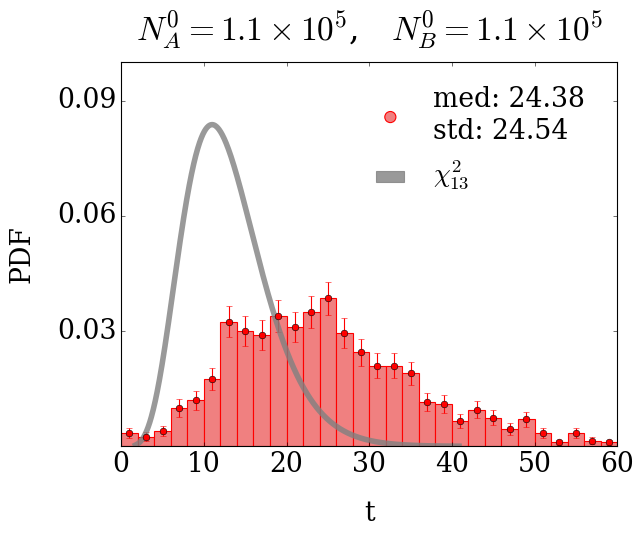

In [22]:
plot_old_t_distribution(exp['1:2_1:2_9wc'],ref_str=['1','2'],bkg_str=['1','2'],df=13,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_109544_ref_size_109544_remastered')

PermissionError: [Errno 13] Permission denied: '/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/example500000epochs_bkg_size_43817_ref_size_175270_remastered_1distribution.pdf'

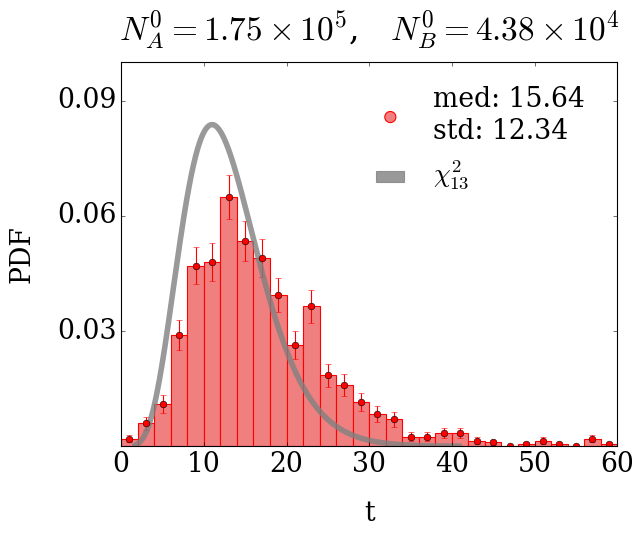

In [23]:
plot_old_t_distribution(exp['4:5_1:5_9wc'],ref_str=['4','5'],bkg_str=['1','5'],df=13,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_43817_ref_size_175270_remastered')

PermissionError: [Errno 13] Permission denied: '/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/example500000epochs_bkg_size_14606_ref_size_175270_remastered_1distribution.pdf'

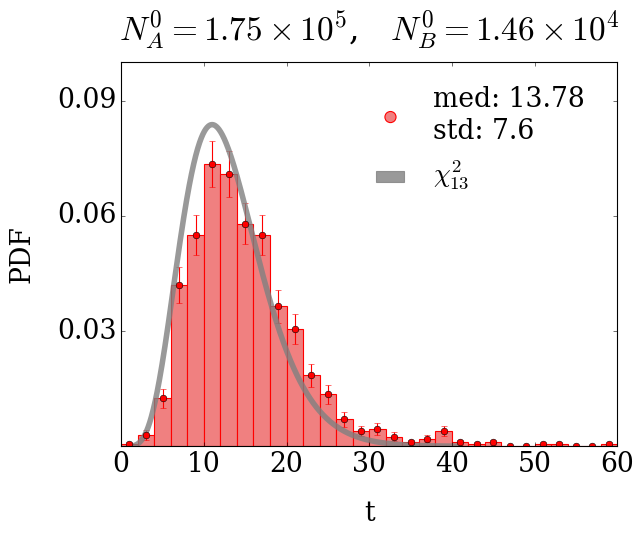

In [24]:
plot_old_t_distribution(exp['4:5_1:15_9wc'],ref_str=['4','5'],bkg_str=['1','15'],df=13,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_14606_ref_size_175270_remastered')

In [25]:
em = {}

In [26]:
em['1:2_1:2_9wc_NPLM'] =  np.loadtxt('/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/em500000epochs_tau0signals_1:2Ref_1:2Bkg.csv',delimiter=',',usecols=0)

In [27]:
em['4:5_1:15_100wc_NPLM'] =  np.loadtxt('/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes/em500000epochs_tau100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv',delimiter=',',usecols=0)

FileNotFoundError: /srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes/em500000epochs_tau100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv not found.

In [28]:
em['1:4_1:4_9wc_NPLM'] =  np.loadtxt('/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/em500000epochs_tau0signals_1:4Ref_1:4Bkg.csv',delimiter=',',usecols=0)

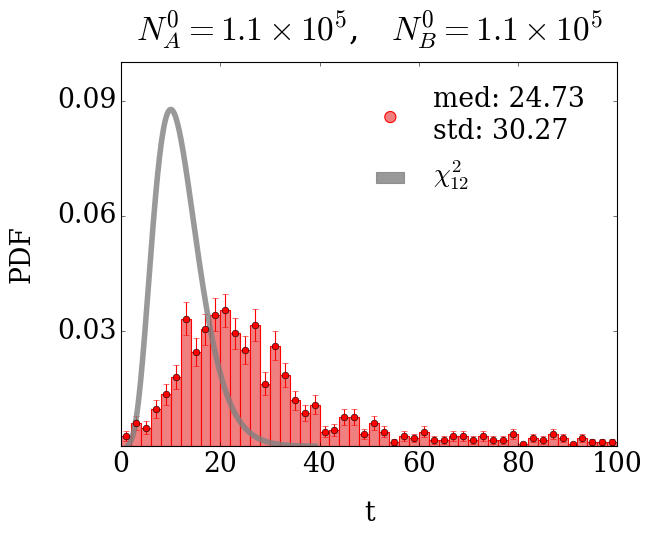

In [29]:
plot_old_t_distribution(em['1:2_1:2_9wc_NPLM'],ref_str=['1','2'],bkg_str=['1','2'],df=12,xmax=100,nbins=50,save=False,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_14606_ref_size_175270_remastered')

$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


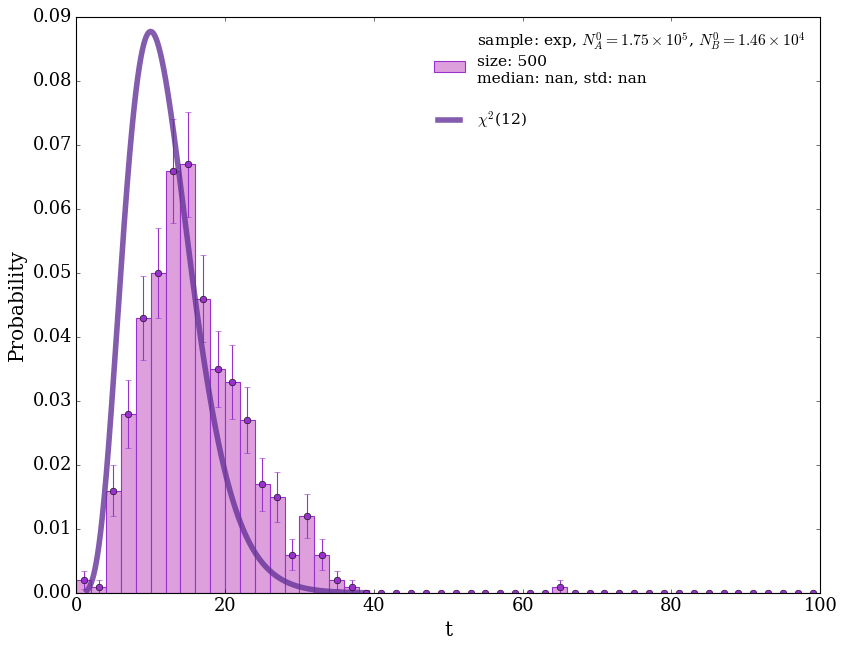

In [99]:
plot_old_t_distribution(em['4:5_1:15_100wc_NPLM'],ref_str=['4','5'],bkg_str=['1','15'],df=12,xmax=100,nbins=50,save=False,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_14606_ref_size_175270_remastered')

$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


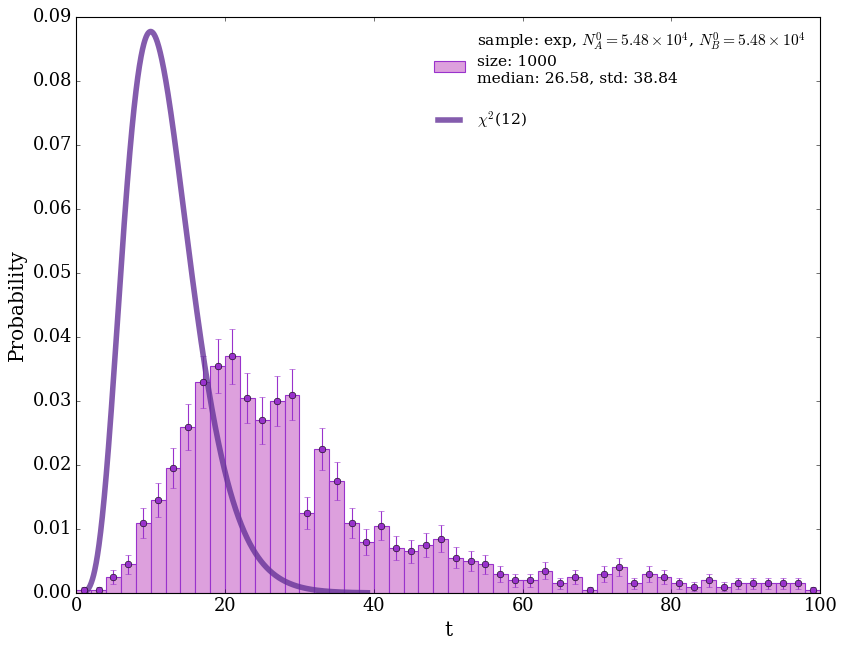

In [92]:
plot_old_t_distribution(em['1:4_1:4_9wc_NPLM'],ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=100,nbins=50,save=False,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_14606_ref_size_175270_remastered')

In [60]:
t_dict = {}
w=['9','100','None']
signals = range(0,3001,100)#[0,100,300,600,1000,1500,2100,2800]
new_train_test_sizes = [['4:5','1:5'],['4:5','1:15'],['1:2','1:2'],['1:4','1:4'],['1:8','1:8'],['1:16','1:16'],['1:2','1:24'],['13:30','13:30'],['100:101','1:101']]
new_sizes = ['4:5_1:5','4:5_1:15','1:2_1:2','1:4_1:4','1:8_1:8','1:16_1:16','1:2_1:24','13:30_13:30','100:101_1:101']
dir = "/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes"
for sig in signals:
    for k in range(len(new_train_test_sizes)):
        if ((new_sizes[k]=='4:5_1:5') or (new_sizes[k]=='1:2_1:2')) or (new_sizes[k]=='100:101_1:101') :
            pdf = '/pdf_'
        else:
            pdf = '/' 
        for wc in w:
            TAU_names = []
            TAU_tmp = []
            delta_names = []
            delta_tmp = []
            TAU_names_Yuval = []
            TAU_tmp_Yuval = []
            delta_names_Yuval = []
            delta_tmp_Yuval = []
            if wc=='9':
                name = f'{pdf}em500000*patience*a{sig}sig*{new_train_test_sizes[k][0]}Ref_{new_train_test_sizes[k][1]}Bkg*.csv'
            else:
                name = f'{pdf}em500000*patience*{wc}*g{sig}sig*{new_train_test_sizes[k][0]}Ref_{new_train_test_sizes[k][1]}Bkg*.csv'

        
            files = glob.glob(dir+name)
            print(files)
            files_Yuval = glob.glob(f'/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes'+name)
            print(files_Yuval)
            for file in files:
                with open(file,'r') as f:
                    lines = f.readlines()
                    TAU_names = [tau.split(',')[1] for tau in lines if tau.count('TAU.')]
                    TAU_tmp = np.array([float(tau.split(',')[0]) for tau in lines if tau.count('TAU.')])
                    delta_names = [delta.split(',')[1] for delta in lines if delta.count('delta.')]
                    delta_tmp = np.array([float(delta.split(',')[0]) for delta in lines if delta.count('delta.')])
                
            for file in files_Yuval:
                with open(file,'r') as f:
                    lines = f.readlines()
                    TAU_names_Yuval = [tau.split(',')[1] for tau in lines if tau.count('TAU.')]
                    TAU_tmp_Yuval = np.array([float(tau.split(',')[0]) for tau in lines if tau.count('TAU.')])
                    delta_names_Yuval = [delta.split(',')[1] for delta in lines if delta.count('delta.')]
                    delta_tmp_Yuval = np.array([float(delta.split(',')[0]) for delta in lines if delta.count('delta.')])
            
            TAU_names=TAU_names+TAU_names_Yuval
            delta_names = delta_names+delta_names_Yuval
            TAU_tmp =np.concatenate((TAU_tmp,TAU_tmp_Yuval),axis=0)
            delta_tmp =np.concatenate((delta_tmp,delta_tmp_Yuval),axis=0)
            #
            try:
                #print(TAU_names[0])
                delta_tau_names = [delta_names[delta_names.index(tau_name.replace("TAU.txt","delta.txt"))] for tau_name in TAU_names if delta_names.count(tau_name.replace("TAU.txt","delta.txt"))>0]
                tot_tmp = np.array([float(TAU_tmp[TAU_names.index(delta_name.replace("delta.txt","TAU.txt"))])+delta_tmp[delta_names.index(delta_name)] for delta_name in delta_tau_names])
            
                t_dict[f'{new_sizes[k]}_sig:{sig}_wc:{wc}'] = tot_tmp
                #     #print([TAU_names[TAU_names.index(delta_name.replace("delta.txt","TAU.txt"))]+delta_names[delta_names.index(delta_name)] for delta_name in delta_names])
                # try:
                #     if file.count('BSMweight_clipping'):
                #         exp_dict[f'{new_sizes[k]}_sig:{sig}_wc:{wc}'] = tot_tmp#TAU_tmp+delta_tmp
                #     else:
                #         exp_dict[f'{new_sizes[k]}_sig:{sig}_wc:9'] = tot_tmp#TAU_tmp+delta_tmp
                # except:
                #     print('TAU_tmp,delta_tmp not same size')
            except:
                print(f'missing:{new_sizes[k]}_sig:{sig}_wc:{wc}')

[]
[]
[]
['/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/pdf_em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_4:5Ref_1:5Bkg.csv']
[]
['/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/pdf_em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_4:5Ref_1:5Bkg.csv']
[]
[]
[]
['/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv']
['/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes/em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_4:5Ref_1:15Bkg.csv']
[]
[]
[]
[]
['/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/pdf_em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:2Ref_1:2Bkg.csv']
[]
['/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/pdf_em500000epochs_tau500000epochs

In [61]:
jobs_folder = '/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/'
wc = [9]#[1.25]
TAU_dict = {}
dir = "/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes"
train_test_sizes=[['1:2','1:2'],['4:5','1:15'],['1:4','1:4']]#[['4:5','1:15']]#[['49:100','49:100'],['4:5','1:15']]#[['1:2','1:2'],['4:5','1:15']]
sizes=['1:2_1:2','4:5_1:15','1:4_1:4']
for i in wc:
    for j in range(len(train_test_sizes)):
        for k in [0]:#range(0,401,40):
            csv_file = jobs_folder+f'em500000epochs_tau{k}signals_{train_test_sizes[j][0]}Ref_{train_test_sizes[j][1]}Bkg.csv'
            try:
                with open(csv_file,'r') as taus:
                    TAU_tmp = np.array([float(tau.split(',')[0]) for tau in taus.readlines()])
                TAU_dict[f"t_{sizes[j]}_wc{i}_sig{k}"] = TAU_tmp
                print(csv_file)
            except:
                print(csv_file)
                print("no t")

/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/em500000epochs_tau0signals_1:2Ref_1:2Bkg.csv
/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/em500000epochs_tau0signals_4:5Ref_1:15Bkg.csv
/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/em500000epochs_tau0signals_1:4Ref_1:4Bkg.csv


In [62]:
wc = [100]#[1.25]
#TAU_dict = {}
dir = "/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes"
train_test_sizes=[['4:5','1:15']]#[['49:100','49:100'],['4:5','1:15']]#[['1:2','1:2'],['4:5','1:15']]
sizes=['4:5_1:15']#['1:2_1:2','4:5_1:15']
for i in wc:
    for j in range(len(train_test_sizes)):
        for k in [0]:#range(0,401,40):
            try:
                csv_file = dir+f'/em500000epochs_tau{i}BSMweight_clipping{k}signals_{train_test_sizes[j][0]}Ref_{train_test_sizes[j][1]}Bkg.csv'
                print(csv_file)
                with open(csv_file,'r') as taus:
                    TAU_tmp = np.array([float(tau.split(',')[0]) for tau in taus.readlines()])
                TAU_dict[f"t_{sizes[j]}_wc{i}_sig{k}"] = TAU_tmp
            except:
                print("no t")

/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes/em500000epochs_tau100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv


NumOfNans1:  0 NumOfNans2:  23


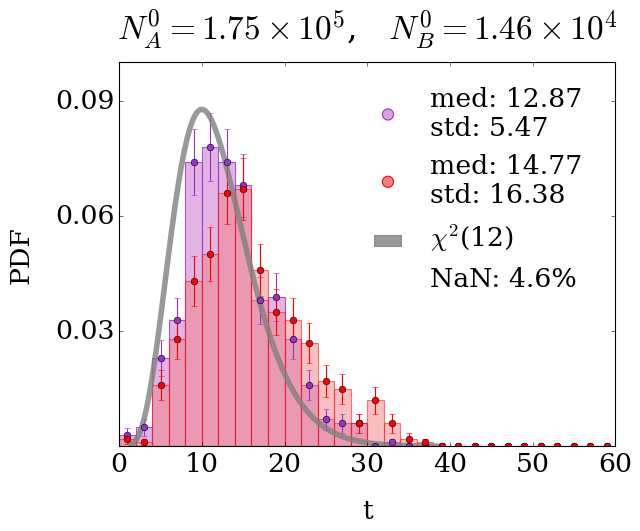

In [63]:
symmetrized_0sig_100wc_4_5_1_15 = t_dict["4:5_1:15_sig:0_wc:100"]
NPLM_0sig_100wc_4_5_1_15 = TAU_dict["t_4:5_1:15_wc100_sig0"]
plot_old_t_2distributions(symmetrized_0sig_100wc_4_5_1_15, NPLM_0sig_100wc_4_5_1_15, ref_str=['4','5'], bkg_str=['1','15'], df=12, xmax=60, nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_175e3_ref_size_146e2_remastered')

NumOfNans1:  0 NumOfNans2:  0


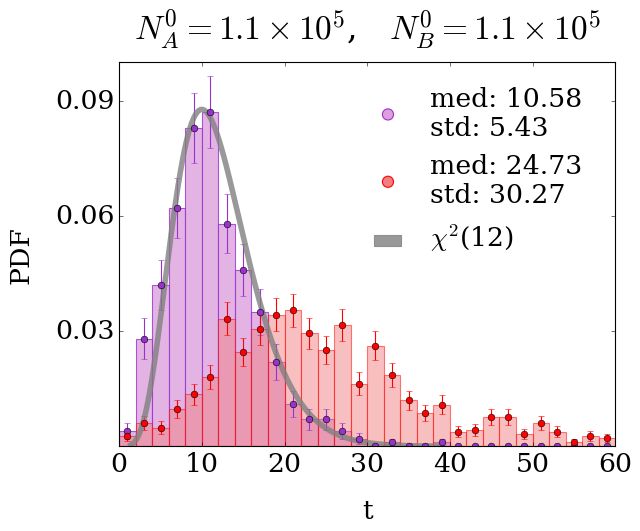

In [64]:
symmetrized_0sig_0wc_1_2_1_2 = t_dict["1:2_1:2_sig:0_wc:None"]
NPLM_0sig_9wc_1_2_1_2 = TAU_dict["t_1:2_1:2_wc9_sig0"]
plot_old_t_2distributions(symmetrized_0sig_0wc_1_2_1_2, NPLM_0sig_9wc_1_2_1_2, ref_str=['1','2'], bkg_str=['1','2'], df=12, xmax=60, nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_11e4_ref_size_11e4_remastered')

NumOfNans1:  0 NumOfNans2:  0


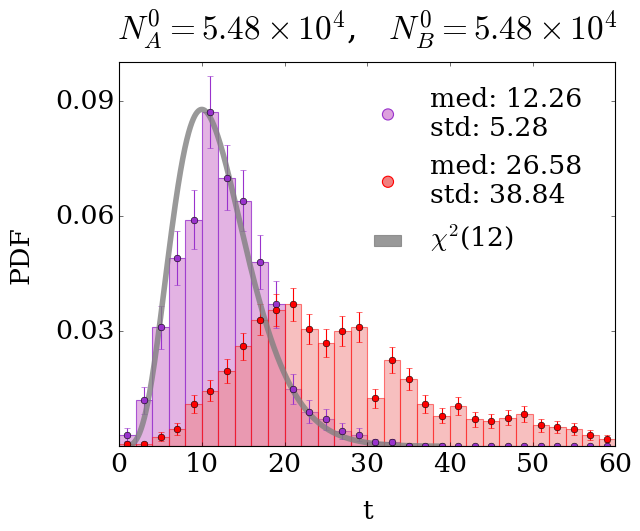

In [65]:
symmetrized_0sig_0wc_1_4_1_4 = t_dict["1:4_1:4_sig:0_wc:None"]
NPLM_0sig_9wc_1_4_1_4 = TAU_dict["t_1:4_1:4_wc9_sig0"]
plot_old_t_2distributions(symmetrized_0sig_0wc_1_4_1_4, NPLM_0sig_9wc_1_4_1_4, ref_str=['1','4'], bkg_str=['1','4'], df=12, xmax=60, nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='example500000epochs_bkg_size_548e2_ref_size_548e2_remastered')

In [18]:
#exp_dict = {}
w=["None"]
Npoiss = ["True"]
signals = [0]
new_train_test_sizes = [['1:2','1:2']]
new_sizes = ['1:2_1:2']
dir = "/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes"
seeds = {}
seed = []
start = 'seed'
end = '_'
delta_dict={}
tau_dict={}
exp_dict={}
for sig in signals:
    for k in range(len(new_train_test_sizes)):
        for wc in w:
            for npoiss in Npoiss:
                N_poiss = npoiss+"N_poiss" if len(npoiss)>0 else npoiss
                TAU_names = []
                TAU_tmp = []
                delta_names = []
                delta_tmp = []
                TAU_names_Yuval = []
                TAU_tmp_Yuval = []
                delta_names_Yuval = []
                delta_tmp_Yuval = []
                if wc=="9":
                    name = f'/exp1500000*patience*a{N_poiss}{sig}sig*{new_train_test_sizes[k][0]}Ref_{new_train_test_sizes[k][1]}Bkg.csv'
                else:
                    name = f'/exp1500000*patience*{wc}*g{N_poiss}{sig}sig*{new_train_test_sizes[k][0]}Ref_{new_train_test_sizes[k][1]}Bkg.csv'

            
                files = glob.glob(dir+name)
                print(files)
                files_Yuval = glob.glob(f'/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/old_exp'+name)
                print(files_Yuval)
                for file in files:
                    with open(file,'r') as f:
                        lines = f.readlines()
                        TAU_names = [tau.split(',')[1] for tau in lines if tau.count('TAU.')]
                        TAU_tmp = np.array([float(tau.split(',')[0]) for tau in lines if tau.count('TAU.')])
                        delta_names = [delta.split(',')[1] for delta in lines if delta.count('delta.')]
                        delta_tmp = np.array([float(delta.split(',')[0]) for delta in lines if delta.count('delta.')])
                    
                for file in files_Yuval:
                    with open(file,'r') as f:
                        lines = f.readlines()
                        TAU_names_Yuval = [tau.split(',')[1] for tau in lines if tau.count('TAU.')]
                        TAU_tmp_Yuval = np.array([float(tau.split(',')[0]) for tau in lines if tau.count('TAU.')])
                        delta_names_Yuval = [delta.split(',')[1] for delta in lines if delta.count('delta.')]
                        delta_tmp_Yuval = np.array([float(delta.split(',')[0]) for delta in lines if delta.count('delta.')])
                
                TAU_names=TAU_names+TAU_names_Yuval
                delta_names = delta_names+delta_names_Yuval
                TAU_tmp =np.concatenate((TAU_tmp,TAU_tmp_Yuval),axis=0)
                delta_tmp =np.concatenate((delta_tmp,delta_tmp_Yuval),axis=0)
                #
                try:
                    #print(TAU_names[0])
                    delta_tau_names = [delta_names[delta_names.index(tau_name.replace("TAU.txt","delta.txt"))] for tau_name in TAU_names if delta_names.count(tau_name.replace("TAU.txt","delta.txt"))>0]
                    tot_tmp = np.array([float(TAU_tmp[TAU_names.index(delta_name.replace("delta.txt","TAU.txt"))])+delta_tmp[delta_names.index(delta_name)] for delta_name in delta_tau_names])
                    #tot_tmp = np.array([float(TAU_tmp[TAU_names.index(delta_name.replace("delta.txt","TAU.txt"))])+delta_tmp[delta_names.index(delta_name)] for delta_name in delta_names])
                    seeds[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k'] = [delta_name[delta_name.find(start)+len(start):delta_name.rfind(end)] for delta_name in delta_tau_names]
                    delta_dict[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k'] = np.array([delta_tmp[delta_names.index(delta_name)] for delta_name in delta_tau_names])
                    tau_dict[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k'] = np.array([float(TAU_tmp[TAU_names.index(delta_name.replace("delta.txt","TAU.txt"))]) for delta_name in delta_tau_names])
                    exp_dict[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k'] = tot_tmp
                    #     #print([TAU_names[TAU_names.index(delta_name.replace("delta.txt","TAU.txt"))]+delta_names[delta_names.index(delta_name)] for delta_name in delta_names])
                    # try:
                    #     if file.count('BSMweight_clipping'):
                    #         exp_dict[f'{new_sizes[k]}_sig:{sig}_wc:{wc}'] = tot_tmp#TAU_tmp+delta_tmp
                    #     else:
                    #         exp_dict[f'{new_sizes[k]}_sig:{sig}_wc:9'] = tot_tmp#TAU_tmp+delta_tmp
                    # except:
                    #     print('TAU_tmp,delta_tmp not same size')
                except:
                    print(f'missing:{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}')
            

[]
['/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/old_exp/exp1500000epochs_tau1500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv']


In [19]:
w=["None"]
Npoiss = ["True"]
signals = [0]
new_train_test_sizes = [['1:2','1:2']]
new_sizes = ['1:2_1:2']
tau_overfits = {}
delta_overfits = {}
for sig in [0]:#signals:
    for k in range(len(new_train_test_sizes)):
        train_size = new_train_test_sizes[k][0].replace(":","/")
        test_size = new_train_test_sizes[k][1].replace(":","/")
        for wc in ["None"]:#w:
            for npoiss in ["True"]:#Npoiss:
                N_poiss = npoiss=="True"
                tau_overfit = []
                delta_overfit = []
                for seed in seeds[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k']:
                    Ref,Bkg,Sig = new_setting.exp(round(219087*float(Fraction(train_size))),round(219087*float(Fraction(test_size))),0,int(seed), N_poiss =N_poiss)
                    NA = len(Ref)
                    ND = len(Bkg)
                    r = ["r" for x in range(0,NA)]
                    b = ["b" for x in range(0,ND)]
                    rb = np.concatenate((r,b))
                    tot = np.concatenate((Ref,Bkg),axis =0).flatten()
                    rb = rb[np.argsort(tot)]
                
                    test_str = "".join(rb)
                    res = sorted(re.findall("r" + '+', test_str), key = len)
                    NA_removed = len(res[-1])+len(res[-2])
                    res = sorted(re.findall("b" + '+', test_str), key = len)
                    ND_removed = len(res[-1])+len(res[-2])
                    tau_overfit.append(2*ND*np.log(1+NA_removed/(NA+ND-NA_removed)))
                    delta_overfit.append(2*NA*np.log(1+ND_removed/(NA+ND-ND_removed)))
                tau_overfits[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k'] = tau_overfit
                delta_overfits[f'{new_sizes[k]}_sig:{sig}_wc:{wc}_Npoiss:{npoiss}_epochs:1500k'] = delta_overfit

               

109979 110145 0
defs: exp, N_Ref=109544,N_Bkg=109544,N_Sig=0,seed = 258198,Scale=0,Norm=0,Sig_loc=6.4,Sig_scale=0.16, N_poiss = True, resonant = True
Ref (110145, 1) Bkg (109979, 1) Sig (0, 1)
109384 109582 0
defs: exp, N_Ref=109544,N_Bkg=109544,N_Sig=0,seed = 789248,Scale=0,Norm=0,Sig_loc=6.4,Sig_scale=0.16, N_poiss = True, resonant = True
Ref (109582, 1) Bkg (109384, 1) Sig (0, 1)
109603 109817 0
defs: exp, N_Ref=109544,N_Bkg=109544,N_Sig=0,seed = 963927,Scale=0,Norm=0,Sig_loc=6.4,Sig_scale=0.16, N_poiss = True, resonant = True
Ref (109817, 1) Bkg (109603, 1) Sig (0, 1)
109178 109867 0
defs: exp, N_Ref=109544,N_Bkg=109544,N_Sig=0,seed = 231914,Scale=0,Norm=0,Sig_loc=6.4,Sig_scale=0.16, N_poiss = True, resonant = True
Ref (109867, 1) Bkg (109178, 1) Sig (0, 1)
109214 109735 0
defs: exp, N_Ref=109544,N_Bkg=109544,N_Sig=0,seed = 672017,Scale=0,Norm=0,Sig_loc=6.4,Sig_scale=0.16, N_poiss = True, resonant = True
Ref (109735, 1) Bkg (109214, 1) Sig (0, 1)
109672 109366 0
defs: exp, N_Ref=10

NumOfNans1:  0 NumOfNans2:  0


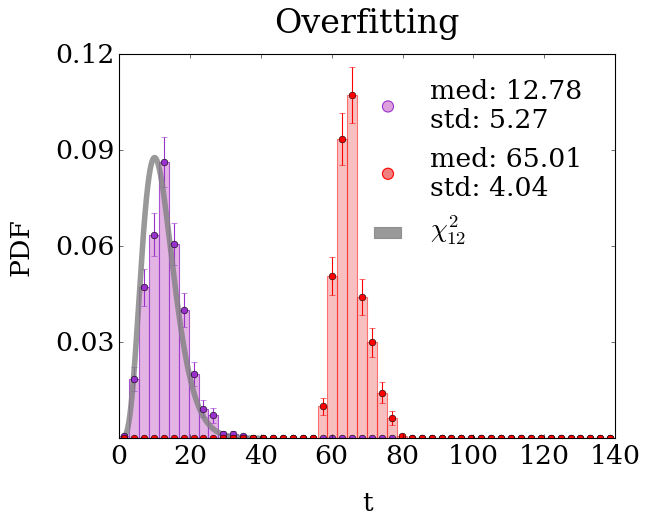

In [20]:
long_training_1500k_1_2_1_2 = exp_dict[f'1:2_1:2_sig:0_wc:None_Npoiss:{"True"}_epochs:1500k']
overfitting_1_2_1_2 = np.array(tau_overfits[f'1:2_1:2_sig:0_wc:None_Npoiss:{"True"}_epochs:1500k'])+np.array(delta_overfits[f'1:2_1:2_sig:0_wc:None_Npoiss:{"True"}_epochs:1500k'])
plot_old_t_2distributions(long_training_1500k_1_2_1_2, overfitting_1_2_1_2, ref_str=['1','2'], bkg_str=['1','2'], df=12, xmax=140, ymax=0.12, title='Overfitting', nbins=50,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='overfitting_remastered')

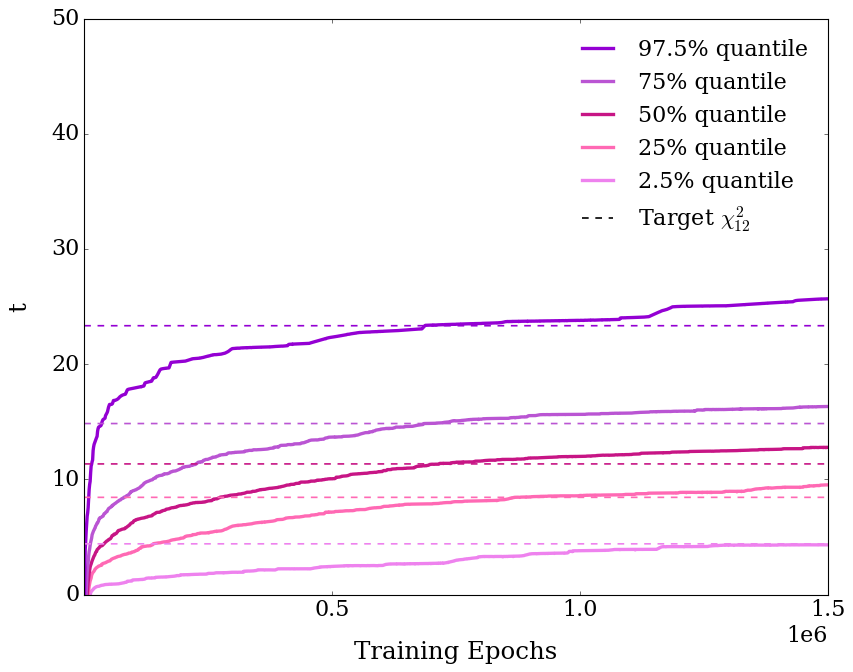

<Figure size 640x480 with 0 Axes>

In [26]:
exp_with_1500000_1_2_1_2 = au.exp_results("exp1500000epochs_tau1500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv")
# Plot_Percentiles_ref(exp_with_1500000_1_2_1_2,12,ymax=50,xmax=1500000, save=True, save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/', file_name='Percentiles_plot_1:2_1:2')
pu.Plot_Percentiles_ref(exp_with_1500000_1_2_1_2,12,ymax=50,xmax=1500000, save=True, save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/', file_name='Percentiles_plot_1:2_1:2')

# More Bkg-only plots

In [29]:
more_Bkg = {}

In [30]:
more_Bkg['1:2_1:2'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:2Ref_1:2Bkg.csv') 
more_Bkg['1_1:10'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1:10Bkg.csv')
more_Bkg['1_1:100'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1:100Bkg.csv')
more_Bkg['1:2_1:2_0.05cp'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv')
more_Bkg['1_1:10_0.05cp'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:10Bkg.csv') 
more_Bkg['1_1:100_0.05cp'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:100Bkg.csv')

$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


$2.19\times {10}^{5}$
$2.19\times {10}^{4}$


$2.19\times {10}^{5}$
$2.19\times {10}^{3}$


$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


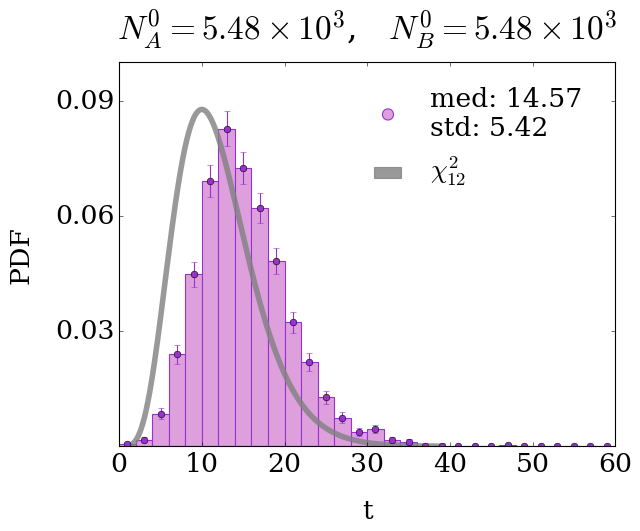

$1.1\times {10}^{4}$
$1.09\times {10}^{3}$


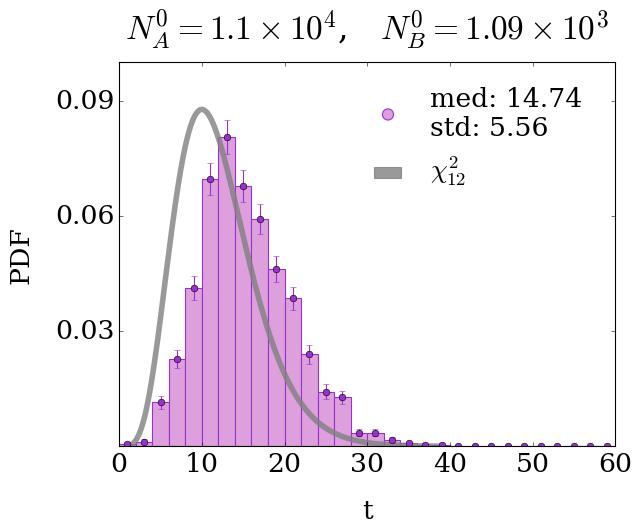

$1.1\times {10}^{4}$
$1.09\times {10}^{2}$


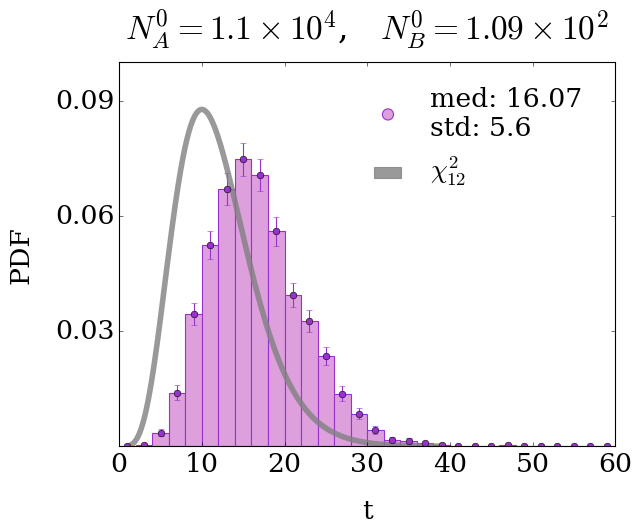

In [31]:
for Bkg_file in more_Bkg.values():
    pu.plot_t_distribution(Bkg_file,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=Bkg_file.csv_file_name.replace('.csv',''))

In [32]:
more_Bkg['NPLM_Nonewc_1:2_1:2'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv') 
more_Bkg['NPLM_Nonewc_1_1:10'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1:10Bkg.csv')
more_Bkg['NPLM_Nonewc_1_1:100'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1:100Bkg.csv')
more_Bkg['NPLM_9wc_1:2_1:2'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMTrueN_poiss0signals_1:2Ref_1:2Bkg.csv') 
more_Bkg['NPLM_9wc_1_1:10'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMTrueN_poiss0signals_1Ref_1:10Bkg.csv')
more_Bkg['NPLM_9wc_1_1:100'] = au.exp_results('exp500000epochs_tauTrueNPLMTrueN_poiss0signals_1Ref_1:100Bkg.csv')
more_Bkg['SYM_9wc_1:2_1:2'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaTrueN_poiss0signals_1:2Ref_1:2Bkg.csv') 
more_Bkg['SYM_9wc_1_1:10'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaTrueN_poiss0signals_1Ref_1:10Bkg.csv')
more_Bkg['SYM_9wc_1_1:100'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaTrueN_poiss0signals_1Ref_1:100Bkg.csv')

NPLM_Nonewc_1:2_1:2
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


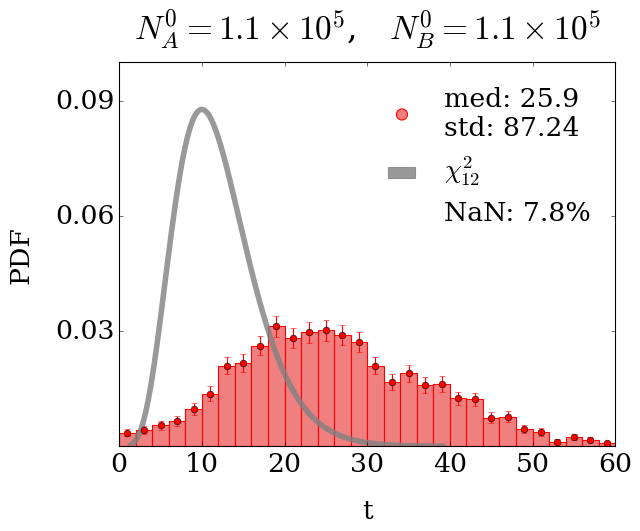

NPLM_Nonewc_1_1:10


tar (child): /srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/exp500000epochs_tau500000epochs_deltaTrueNPLMNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1\:10Bkg.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


$2.19\times {10}^{5}$
$2.19\times {10}^{4}$


NPLM_Nonewc_1_1:100


tar (child): /srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/exp500000epochs_tau500000epochs_deltaTrueNPLMNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1\:100Bkg.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


$2.19\times {10}^{5}$
$2.19\times {10}^{3}$


NPLM_9wc_1:2_1:2
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


NPLM_9wc_1_1:10
$2.19\times {10}^{5}$
$2.19\times {10}^{4}$


NPLM_9wc_1_1:100


tar (child): /srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/exp500000epochs_tauTrueNPLMTrueN_poiss0signals_1Ref_1\:100Bkg.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


$2.19\times {10}^{5}$
$2.19\times {10}^{3}$


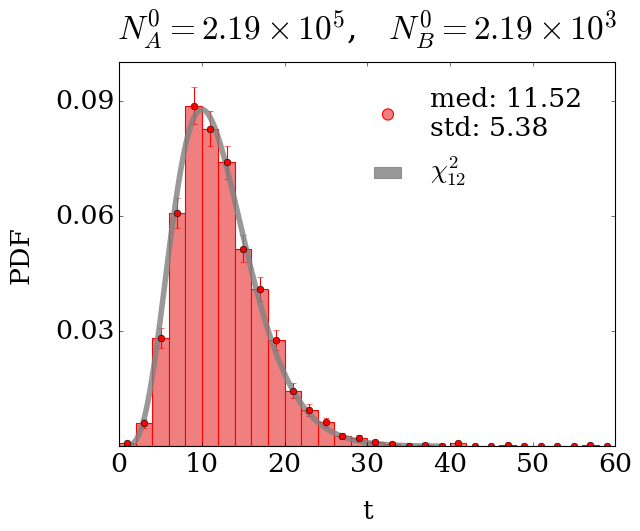

In [33]:
for k in more_Bkg.keys():
    if k.startswith('NPLM'):
        print(k)
        pu.plot_t_distribution(more_Bkg[k],df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=k)
    # if k.startswith('SYM'):
    #     print(k)
    #     pu.plot_t_distribution(more_Bkg[k],df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=k)

In [9]:
more_Bkg = {}
more_Bkg['SYM_9wc_1:2_1:2'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaTrueN_poiss0signals_1:2Ref_1:2Bkg.csv') 
more_Bkg['SYM_9wc_1_1:10'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaTrueN_poiss0signals_1Ref_1:10Bkg.csv')
more_Bkg['SYM_9wc_1_1:100'] = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaTrueN_poiss0signals_1Ref_1:100Bkg.csv')

In [10]:
for k in more_Bkg.keys():
    if k.startswith('NPLM'):
        print(k)
        pu.plot_t_distribution(more_Bkg[k],df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=k)
    if k.startswith('SYM'):
        print(k)
        pu.plot_t_distribution(more_Bkg[k],df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=k)

SYM_9wc_1:2_1:2
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


SYM_9wc_1_1:10
$2.19\times {10}^{5}$
$2.19\times {10}^{4}$


SYM_9wc_1_1:100
$2.19\times {10}^{5}$
$2.19\times {10}^{3}$


In [11]:
more_Bkg = {}
more_Bkg['NPLM_9wc_1:2_1:2'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMTrueN_poiss0signals_1:2Ref_1:2Bkg.csv') 
more_Bkg['NPLM_9wc_1_1:10'] = au.exp_results('exp500000epochs_tau500000epochs_deltaTrueNPLMTrueN_poiss0signals_1Ref_1:10Bkg.csv')
more_Bkg['NPLM_9wc_1_1:100'] = au.exp_results('exp500000epochs_tauTrueNPLMTrueN_poiss0signals_1Ref_1:100Bkg.csv')

In [13]:
pu.exp_performance_plot([more_Bkg['NPLM_9wc_1:2_1:2'],more_Bkg['NPLM_9wc_1_1:10'],more_Bkg['NPLM_9wc_1_1:100']],1,save=False)

exp500000epochs_tauFalseNPLMTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant300signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant40signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant10signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant70signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant400signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant50signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant30signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLMTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
exp500000epochs_tau500000epochs_deltaTrueNPLM6.4Sig_locTrueN_poissTrueresonant60signals_1:2Ref_1:2Bkg.csv
e

### $e\mu$ background only plots

In [27]:
em_Bkg_1_8_1_8 = au.em_results('em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:8Ref_1:8Bkg.csv')
em_Bkg_1_4_1_4 = au.em_results('em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:4Ref_1:4Bkg.csv')
em_Bkg_3_8_3_8 = au.em_results('em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_3:8Ref_3:8Bkg.csv')
em_Bkg_1_2_1_2 = au.em_results('em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv')

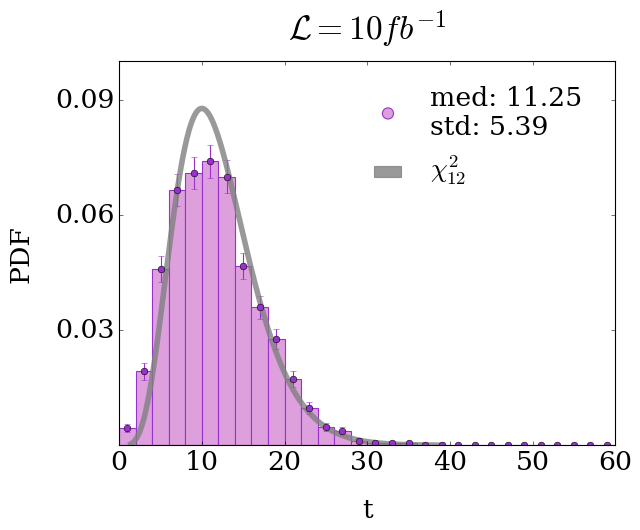

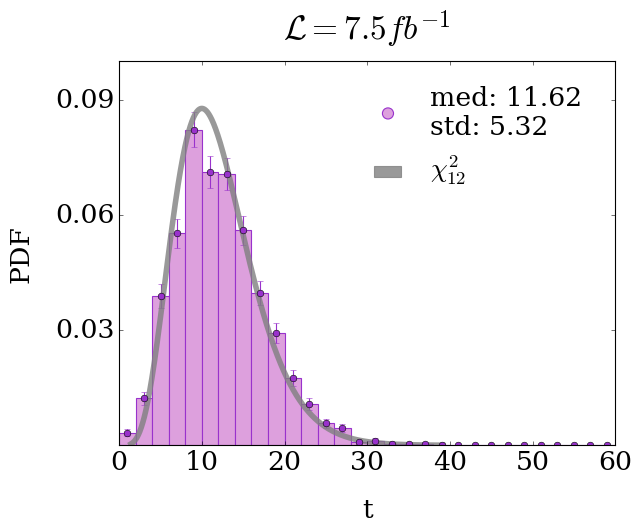

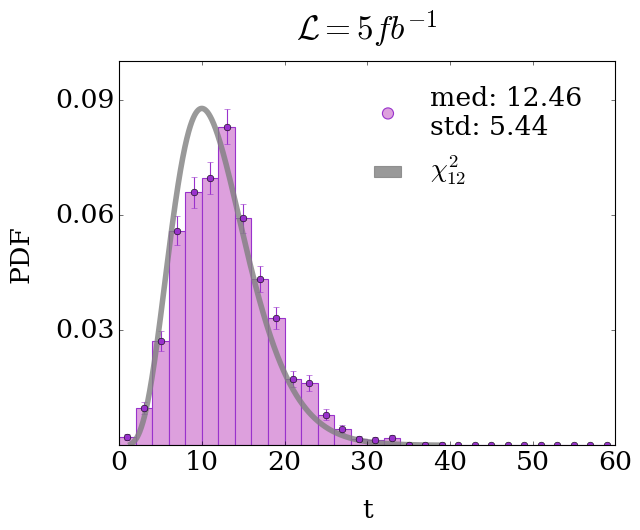

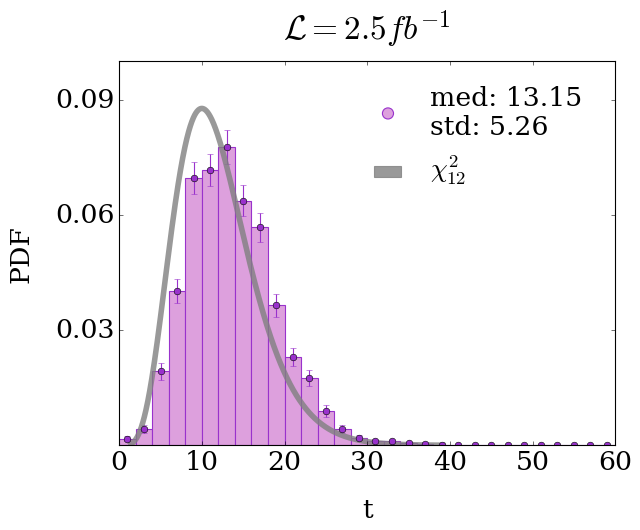

In [28]:
lumi = [10,7.5,5,2.5]
for i,s in enumerate([em_Bkg_1_2_1_2,em_Bkg_3_8_3_8,em_Bkg_1_4_1_4,em_Bkg_1_8_1_8]):
    # pu.plot_t_distribution(s,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=s.csv_file_name.replace('.csv',''))
    pu.plot_t_distribution(s,df=12,xmax=60,nbins=30,title = f'$\\mathcal{{L}}={lumi[i]}{{fb}}^{{-1}}$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=s.csv_file_name.replace('.csv','_lumi_title'))

In [4]:
em_Sig_700_1_2_1_2 = au.em_results('em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss700signals_1:2Ref_1:2Bkg.csv')

In [5]:
z, sig, bkg = au.get_z_score(em_Sig_700_1_2_1_2, em_Bkg_1_2_1_2)

In [10]:
alternative_z = (np.median(sig)-np.mean(bkg))/np.std(bkg)

In [11]:
print(z,alternative_z)

2.7477813854449926 3.451154904598382


In [3]:
new_plots_1_2_1_2 = au.exp_results('exp500000epochs_tau500000epochs_delta2000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv')
new_plots_1_1_10 = au.exp_results('exp500000epochs_tau500000epochs_delta2000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:10Bkg.csv')
new_plots_1_1_100 = au.exp_results('exp500000epochs_tau500000epochs_delta2000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:100Bkg.csv')

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


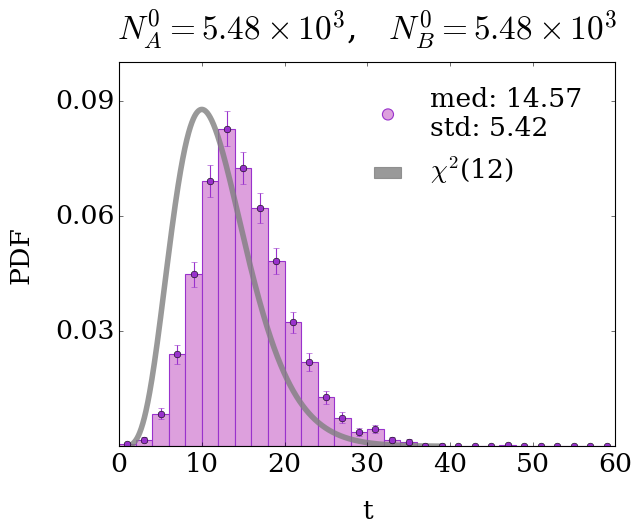

In [7]:
pu.plot_t_distribution(new_plots_1_2_1_2,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg_1distribution.pdf')

In [8]:
pu.plot_t_distribution(new_plots_1_1_10,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:10Bkg_1distribution.pdf')

$1.1\times {10}^{4}$
$1.09\times {10}^{3}$


$1.1\times {10}^{4}$
$1.09\times {10}^{2}$


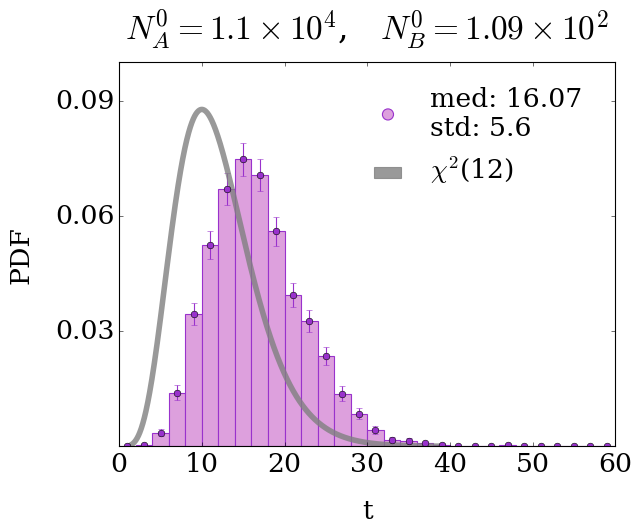

In [9]:
pu.plot_t_distribution(new_plots_1_1_100,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:100Bkg_1distribution.pdf')

### permutation plots

In [3]:
import new_analysis_utils as au
bkg = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv')
sig1 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion100signals_1:2Ref_1:2Bkg.csv')
sig2 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion110signals_1:2Ref_1:2Bkg.csv')
sig3 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion120signals_1:2Ref_1:2Bkg.csv')
sig4 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion130signals_1:2Ref_1:2Bkg.csv')
sig5 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion150signals_1:2Ref_1:2Bkg.csv')
sig6 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion160signals_1:2Ref_1:2Bkg.csv')
sig7 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion170signals_1:2Ref_1:2Bkg.csv')
sig8 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion190signals_1:2Ref_1:2Bkg.csv')
sig9 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion200signals_1:2Ref_1:2Bkg.csv')
sig10 = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion210signals_1:2Ref_1:2Bkg.csv')
for j,i in enumerate([sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,sig9,sig10]):
    print(f"{j+1} z_score: {au.get_z_score(i,bkg)[0]}")

1 z_score: 0.7504229716004978
2 z_score: 1.1749867920660901
3 z_score: 1.2107271327915976
4 z_score: 1.4795252050806598
5 z_score: 1.7928306937637521
6 z_score: 1.986300204129428
7 z_score: 2.17009037758456
8 z_score: 2.7477813854449926
9 z_score: 3.2905267314919255
10 z_score: 3.2905267314919255


In [31]:
import numpy as np
check_seed = au.exp_results('exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant300signals_1:4Ref_1:4Bkg.csv')
t_list = check_seed.read_final_t_csv()
closest_seed_to_median = np.argsort(np.abs(t_list[0]-np.median(t_list[0])))
print(t_list[0][closest_seed_to_median[:3]],np.median(t_list[0]))
print(np.array(t_list[1])[closest_seed_to_median[:3]])
check_seed_500 = au.exp_results('exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant500signals_1:4Ref_1:4Bkg.csv')
t_list_500 = check_seed_500.read_final_t_csv()
closest_seed_to_median_500 = np.argsort(np.abs(t_list_500[0]-np.median(t_list_500[0])))
print(t_list_500[0][closest_seed_to_median_500[:3]],np.median(t_list_500[0]))
print(np.array(t_list_500[1])[closest_seed_to_median_500[:3]])
print(np.sort(t_list_500[0])[len(t_list_500[0])//2-1],np.argsort(t_list_500[0])[len(t_list_500[0])//2-1],closest_seed_to_median_500[1])

[16.807737 16.667023 17.006106] 16.73738
['/storage/tgrp/inbarsav/LFV_nn/training_outcomes/exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant300signals_1:4Ref_1:4Bkg_job53_seed385545_delta.txt\n'
 '/storage/tgrp/inbarsav/LFV_nn/training_outcomes/exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant300signals_1:4Ref_1:4Bkg_job75_seed316640_delta.txt\n'
 '/storage/tgrp/inbarsav/LFV_nn/training_outcomes/exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant300signals_1:4Ref_1:4Bkg_job90_seed213629_delta.txt\n']
[27.385562 26.876357 26.838844] 27.1309595
['/storage/tgrp/inbarsav/LFV_nn/training_outcomes/exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant500signals_1:4Ref_1:4Bkg_job60_seed503053_delta.txt\n'

In [3]:
file_0sigma = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv')
file_1sigma = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion110signals_1:2Ref_1:2Bkg.csv')
file_2sigma = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion160signals_1:2Ref_1:2Bkg.csv')
t_list_0sigma = file_0sigma.read_final_t_csv()
t_list_1sigma = file_1sigma.read_final_t_csv()
t_list_2sigma = file_2sigma.read_final_t_csv()
closest_seed_to_median_0sigma = np.argsort(np.abs(t_list_0sigma[0]-np.median(t_list_0sigma[0])))
closest_seed_to_median_1sigma = np.argsort(np.abs(t_list_1sigma[0]-np.median(t_list_1sigma[0])))
closest_seed_to_median_2sigma = np.argsort(np.abs(t_list_2sigma[0]-np.median(t_list_2sigma[0])))
print(t_list_0sigma[0][closest_seed_to_median_0sigma[:3]],np.median(t_list_0sigma[0]))
print(np.array(t_list_0sigma[1])[closest_seed_to_median_0sigma[:3]])
print(t_list_1sigma[0][closest_seed_to_median_1sigma[:3]],np.median(t_list_1sigma[0]))
print(np.array(t_list_1sigma[1])[closest_seed_to_median_1sigma[:3]])
print(t_list_2sigma[0][closest_seed_to_median_2sigma[:3]],np.median(t_list_2sigma[0]))
print(np.array(t_list_2sigma[1])[closest_seed_to_median_2sigma[:3]])

[14.568465 14.567175 14.563496] 14.56782
['/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg_job217_seed391793_delta.txt\n'
 '/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg_job258_seed411100_delta.txt\n'
 '/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg_job584_seed438983_delta.txt\n']
[21.510614 21.54099  21.607353] 21.525802
['/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion110signals_1:2Ref_1:2Bkg_job21_seed968091_delta.txt\n'
 '/st

In [1]:
import new_analysis_utils as au
import new_plot_utils as pu
import numpy as np
sig_110 = au.exp_results('exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement968091original_seed110signals_1:2Ref_1:2Bkg.csv')
print(len(sig_110))
print(sig_110.read_final_t_csv()[1][:10])
sig_160 = au.exp_results('exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement128151original_seed160signals_1:2Ref_1:2Bkg.csv')
print(len(sig_160))
pu.plot_t_distribution(sig_110,df=12,xmax=60,nbins=30)
pu.plot_t_distribution(sig_160,df=12,xmax=60,nbins=30)

2000
['/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement968091original_seed110signals_1:2Ref_1:2Bkg_job66_seed932557_delta.txt\n', '/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement968091original_seed110signals_1:2Ref_1:2Bkg_job947_seed655798_delta.txt\n', '/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement968091original_seed110signals_1:2Ref_1:2Bkg_job455_seed814492_delta.txt\n', '/storage/agrp/yuvalzu/NPLM/NPLM_package/training_outcomes/exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresona

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$
$1.6\times {10}^{2}$


1022


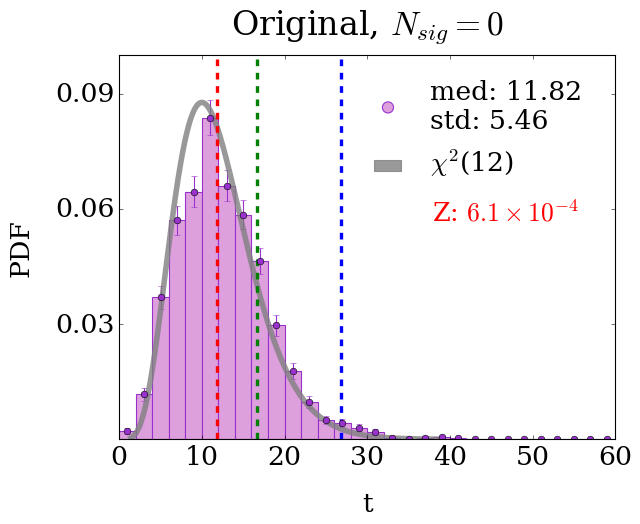

In [87]:
no_permute_bkg = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:4Ref_1:4Bkg.csv')
t_dict = no_permute_bkg.get_t_history_dict()
max_epoch = max(t_dict.keys())
t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
t_vlines = [4.219972+7.656943, 8.235987+8.431036, 13.247002+13.629355]
sig_t = t_vlines[0]
bkg_t=t
z_score = np.sqrt(2)*spc.erfinv((len(bkg_t[bkg_t<=np.median(sig_t)])/len(bkg_t))*2-1)
print(len(bkg_t[bkg_t<=np.median(sig_t)]))
z_score = scientific_number(z_score,1)
plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=0$',
                        save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_bkg_remastered')

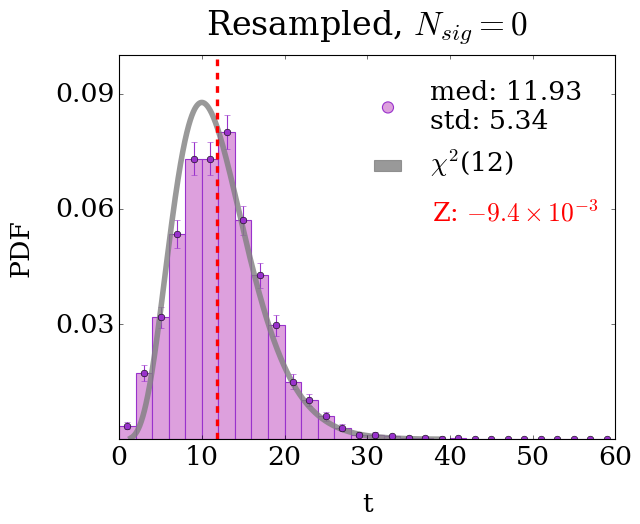

In [88]:
permute_bkg = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping6.4Sig_locTrueN_poissFalseresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement239107original_seed0signals_1:4Ref_1:4Bkg.csv')
t_dict = permute_bkg.get_t_history_dict()
max_epoch = max(t_dict.keys())
t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
t_vlines = [4.219972+7.656943, None, None]
sig_t = t_vlines[0]
z_score = np.sqrt(2)*spc.erfinv((len(t[t<=np.median(sig_t)])/len(t))*2-1)
z_score = scientific_number(z_score,1)
plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Resampled'+r', $N_{sig}=0$',
                        save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_bkg_remastered')

In [91]:
no_permute_300_sig = au.exp_results('exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant300signals_1:4Ref_1:4Bkg.csv')
t_dict = no_permute_300_sig.get_t_history_dict()
max_epoch = max(t_dict.keys())
t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
t_vlines = [None, 8.235987+8.431036, None]
sig_t = t_vlines[1]
z_score = np.sqrt(2)*spc.erfinv((len(bkg_t[bkg_t<=np.median(sig_t)])/len(bkg_t))*2-1)
z_score = scientific_number(z_score,1)
plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=300$',
                        save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_300_sig_remastered')

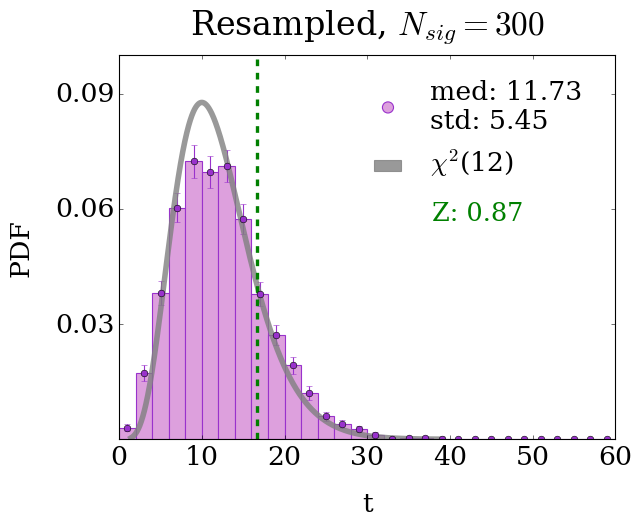

In [92]:
permute_300_sig = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement316640original_seed300signals_1:4Ref_1:4Bkg.csv')
t_dict = permute_300_sig.get_t_history_dict()
max_epoch = max(t_dict.keys())
t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
[None, 8.235987+8.431036, None]
sig_t = t_vlines[1]
z_score = np.sqrt(2)*spc.erfinv((len(t[t<=np.median(sig_t)])/len(t))*2-1)
z_score = scientific_number(z_score,1)
plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Resampled'+r', $N_{sig}=300$',
                        save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_300_sig_remastered')

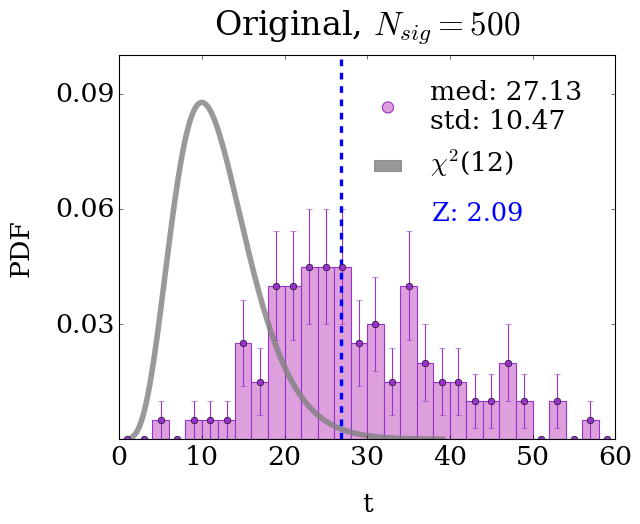

In [52]:
no_permute_500_sig = au.exp_results('exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant500signals_1:4Ref_1:4Bkg.csv')
t_dict = no_permute_500_sig.get_t_history_dict()
max_epoch = max(t_dict.keys())
t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
t_vlines = [None, None, 13.247002+13.629355]
sig_t = t_vlines[2]
z_score = np.sqrt(2)*spc.erfinv((len(bkg_t[bkg_t<=np.median(sig_t)])/len(bkg_t))*2-1)
z_score = scientific_number(z_score,2)
plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=500$',
                        save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_500_sig_remastered')

In [53]:
permute_500_sig = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement841522original_seed500signals_1:4Ref_1:4Bkg.csv')
t_dict = permute_500_sig.get_t_history_dict()
max_epoch = max(t_dict.keys())
t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
t_vlines = [None, None, 13.247002+13.629355]
sig_t = t_vlines[2]
z_score = np.sqrt(2)*spc.erfinv((len(t[t<=np.median(sig_t)])/len(t))*2-1)
z_score = scientific_number(z_score,2)
plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Resampled'+r', $N_{sig}=500$',
                        save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_500_sig_remastered')

In [42]:
no_permute_0sigma_0_05cp = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv')
no_permute_1sigma_0_05cp = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion110signals_1:2Ref_1:2Bkg.csv')
no_permute_2sigma_0_05cp = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion160signals_1:2Ref_1:2Bkg.csv')
permute_0sigma_0_05cp = au.exp_results('exp500000epochs_tauNoneBSMweight_clippingTrueN_poiss0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement411100original_seed0signals_1:2Ref_1:2Bkg.csv')
permute_1sigma_0_05cp = au.exp_results('exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement968091original_seed110signals_1:2Ref_1:2Bkg.csv')
permute_2sigma_0_05cp = au.exp_results('exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement128151original_seed160signals_1:2Ref_1:2Bkg.csv')
# max_epoch = max(t_dict.keys())
# t = t_dict[500000] if 500000 in t_dict.keys() else t_dict[max_epoch]
t_vlines = [t[t<np.median(t)][np.argsort(np.median(t)-t[t<np.median(t)])][0] for t in [no_permute_0sigma_0_05cp.read_final_t_csv()[0],no_permute_1sigma_0_05cp.read_final_t_csv()[0],no_permute_2sigma_0_05cp.read_final_t_csv()[0]]]
sig_t = t_vlines[0]
t = no_permute_0sigma_0_05cp.read_final_t_csv()[0]
bkg_t=t
z_score = np.sqrt(2)*spc.erfinv((len(bkg_t[bkg_t<=np.median(sig_t)])/len(bkg_t))*2-1)
# z_score = au.get_z_score(no_permute_0sigma_0_05cp,no_permute_0sigma_0_05cp)[0]
print(z_score)
# print(len(bkg_t[bkg_t<=np.median(sig_t)]))
z_score = scientific_number(z_score,1)
# plot_old_t_distribution(t,ref_str=['1','4'],bkg_str=['1','4'],df=12,xmax=60,nbins=30,NPLM=False,samples_to_take=2000,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=0$',
#                         save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_bkg_remastered')
pu.plot_t_distribution(no_permute_0sigma_0_05cp,df=12,xmax=60,nbins=30,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=0$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_bkg_0_05cp_remastered')

0.0


0.03


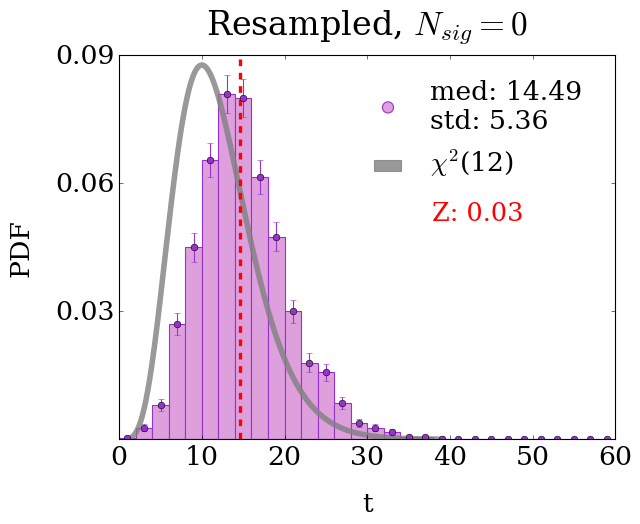

In [60]:
t = permute_0sigma_0_05cp.read_final_t_csv()[0]
t_vlines = [t[t<np.median(t)][np.argsort(np.median(t)-t[t<np.median(t)])][0] for t in [no_permute_0sigma_0_05cp.read_final_t_csv()[0]]] + [None, None]
sig_t = t_vlines[0]
z_score = np.sqrt(2)*spc.erfinv((len(t[t<=np.median(sig_t)])/len(t))*2-1)
z_score = round(z_score,2)
print(z_score)
pu.plot_t_distribution(permute_0sigma_0_05cp,df=12,xmax=60,nbins=30,vlines=t_vlines,add_z=z_score,title='Resampled'+r', $N_{sig}=0$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_bkg_0_05cp_remastered')

1.5571612431404993


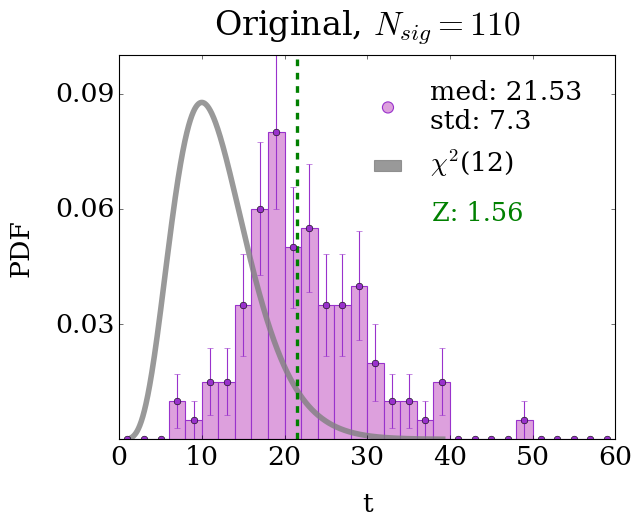

In [55]:
t = no_permute_1sigma_0_05cp.read_final_t_csv()[0]
t_vlines = [None] + [t[t<np.median(t)][np.argsort(np.median(t)-t[t<np.median(t)])][0] for t in [no_permute_1sigma_0_05cp.read_final_t_csv()[0]]] + [None]
sig_t = t_vlines[1]
# bkg_t=t
z_score = np.sqrt(2)*spc.erfinv((len(bkg_t[bkg_t<=np.median(sig_t)])/len(bkg_t))*2-1)
print(z_score)
z_score = scientific_number(z_score,2)
pu.plot_t_distribution(no_permute_1sigma_0_05cp,df=12,xmax=60,nbins=30,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=110$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_110_sig_0_05cp_remastered')

1.2399334778907378


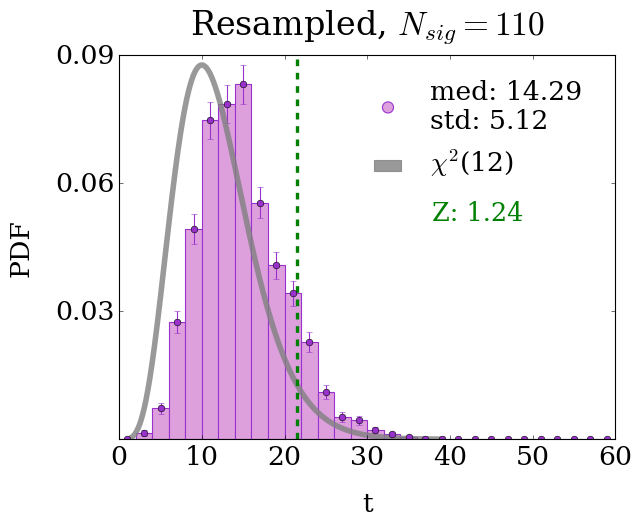

In [56]:
t = permute_1sigma_0_05cp.read_final_t_csv()[0]
t_vlines = [None] + [t[t<np.median(t)][np.argsort(np.median(t)-t[t<np.median(t)])][0] for t in [no_permute_1sigma_0_05cp.read_final_t_csv()[0]]] + [None]
sig_t = t_vlines[1]
z_score = np.sqrt(2)*spc.erfinv((len(t[t<=np.median(sig_t)])/len(t))*2-1)
print(z_score)
z_score = scientific_number(z_score,2)
pu.plot_t_distribution(permute_1sigma_0_05cp,df=12,xmax=60,nbins=30,vlines=t_vlines,add_z=z_score,title='Resampled'+r', $N_{sig}=110$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_110_sig_0_05cp_remastered')

In [57]:
t = no_permute_2sigma_0_05cp.read_final_t_csv()[0]
t_vlines = [None,None] + [t[t<np.median(t)][np.argsort(np.median(t)-t[t<np.median(t)])][0] for t in [no_permute_2sigma_0_05cp.read_final_t_csv()[0]]]
sig_t = t_vlines[2]
z_score = np.sqrt(2)*spc.erfinv((len(bkg_t[bkg_t<=np.median(sig_t)])/len(bkg_t))*2-1)
print(z_score)
z_score = scientific_number(z_score,2)
pu.plot_t_distribution(no_permute_2sigma_0_05cp,df=12,xmax=60,nbins=30,vlines=t_vlines,add_z=z_score,title='Original'+r', $N_{sig}=160$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_160_sig_0_05cp_remastered')

2.2056192429548185


In [58]:
t = permute_2sigma_0_05cp.read_final_t_csv()[0]
t_vlines = [None,None] + [t[t<np.median(t)][np.argsort(np.median(t)-t[t<np.median(t)])][0] for t in [no_permute_2sigma_0_05cp.read_final_t_csv()[0]]]
sig_t = t_vlines[2]
z_score = np.sqrt(2)*spc.erfinv((len(t[t<=np.median(sig_t)])/len(t))*2-1)   
print(z_score)
z_score = scientific_number(z_score,2)
pu.plot_t_distribution(permute_2sigma_0_05cp,df=12,xmax=60,nbins=30,vlines=t_vlines,add_z=z_score,title='Resampled'+r', $N_{sig}=160$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_160_sig_0_05cp_remastered')

2.0857640650923535


In [24]:
no_permute_bkg = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:4Ref_1:4Bkg.csv')
permute_bkg = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping6.4Sig_locTrueN_poissFalseresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement239107original_seed0signals_1:4Ref_1:4Bkg.csv')
no_permute_500_sig = au.exp_results('exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant500signals_1:4Ref_1:4Bkg.csv')
permute_500_sig = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement841522original_seed500signals_1:4Ref_1:4Bkg.csv')
no_permute_0sigma_0_05cp = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv')
permute_0sigma_0_05cp = au.exp_results('exp500000epochs_tauNoneBSMweight_clippingTrueN_poiss0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement411100original_seed0signals_1:2Ref_1:2Bkg.csv')
no_permute_2sigma_0_05cp = au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portion160signals_1:2Ref_1:2Bkg.csv')
permute_2sigma_0_05cp = au.exp_results('exp500000epochs_tauNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0.05combined_portionTrueresamplepermutelabel_methodfixedN_methodTruereplacement128151original_seed160signals_1:2Ref_1:2Bkg.csv')

In [25]:
pu.plot_t_distribution(no_permute_bkg,df=12,xmax=60,ymax=0.119,nbins=30,title='Original'+r', $N_{sig}=0$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_bkg_new')

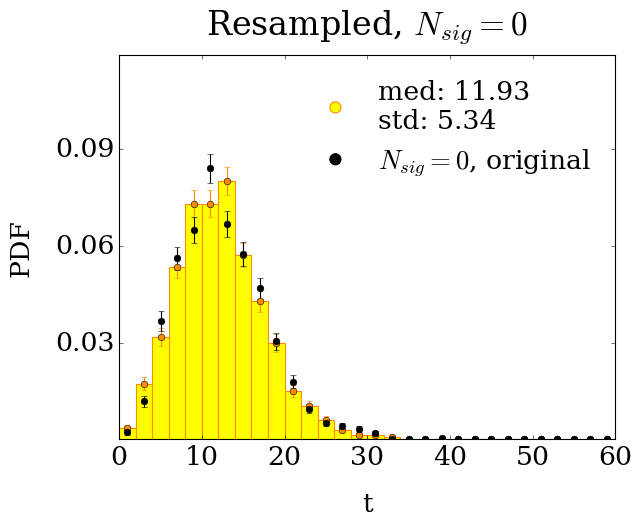

In [4]:
pu.plot_t_2distributions(permute_bkg,no_permute_bkg,df=False,xmax=60,ymax=0.119,nbins=30,colors1=['yellow','darkorange'],colors2=['black','black'],alphas=[1,0],labels=[0,r'$N_{sig}=0$, original'],title='Resampled'+r', $N_{sig}=0$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_bkg_new')

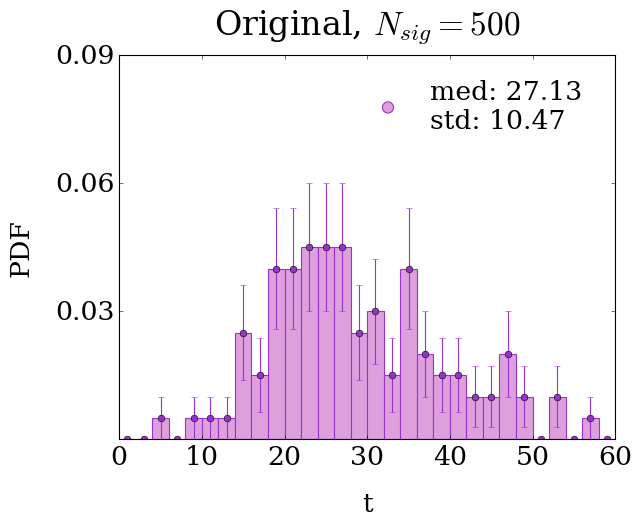

In [14]:
pu.plot_t_distribution(no_permute_500_sig,df=0,xmax=60,nbins=30,title='Original'+r', $N_{sig}=500$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_500_sig_new')

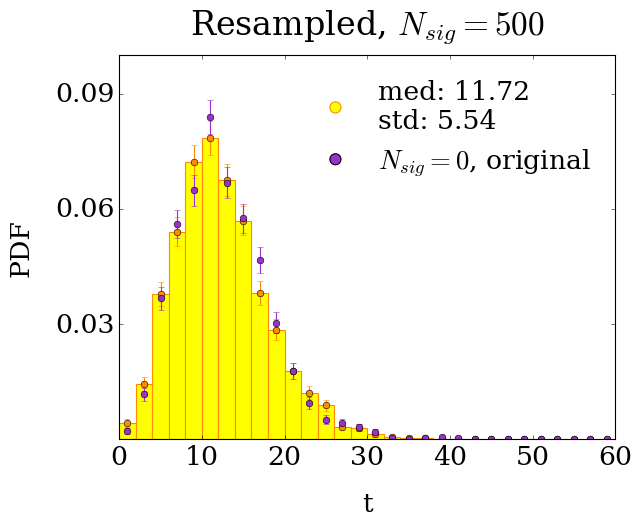

In [15]:
pu.plot_t_2distributions(permute_500_sig,no_permute_bkg,df=False,xmax=60,nbins=30,colors1=['yellow','darkorange'],colors2=['plum','darkorchid'],alphas=[1,0],labels=[0,r'$N_{sig}=0$, original'],title='Resampled'+r', $N_{sig}=500$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_500_sig_new')

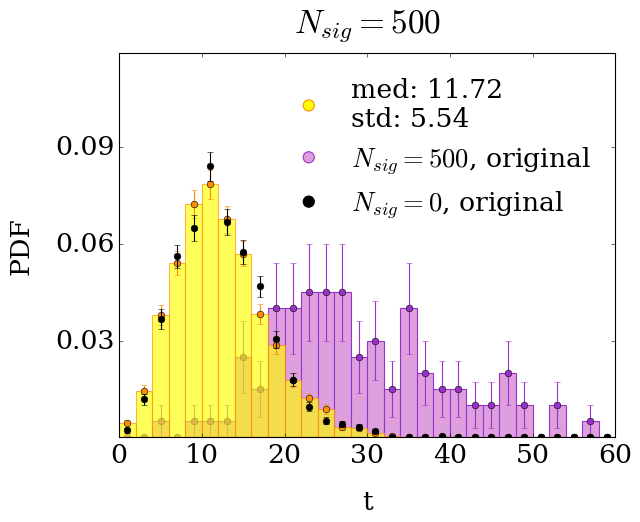

In [8]:
pu.plot_t_multiple_distributions([permute_500_sig,no_permute_500_sig,no_permute_bkg],df=0,xmax=60,ymax=0.119,nbins=30
                                 ,bin_colors=['yellow',0,'black'],edge_colors=['darkorange',0,'black'],alphas=[0.65,1,0]
                                 ,labels=[0,r'$N_{sig}=500$, original',r'$N_{sig}=0$, original'],order=[1,0,2],title=r'$N_{sig}=500$'
                                 ,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_500_sig')

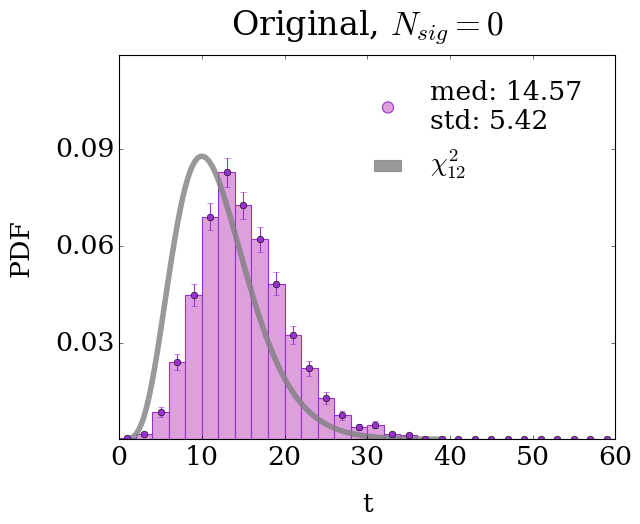

In [26]:
pu.plot_t_distribution(no_permute_0sigma_0_05cp,df=12,xmax=60,ymax=0.119,nbins=30,title='Original'+r', $N_{sig}=0$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_0sigma_0_05cp_new')

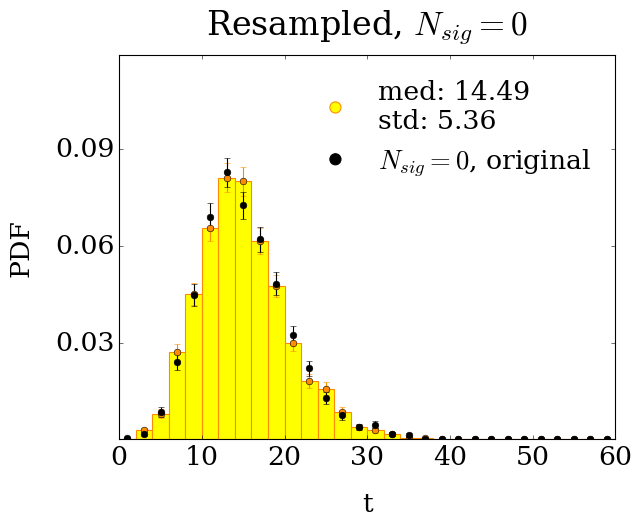

In [5]:
pu.plot_t_2distributions(permute_0sigma_0_05cp,no_permute_0sigma_0_05cp,df=False,xmax=60,ymax=0.119,nbins=30,colors1=['yellow','darkorange'],colors2=['black','black'],alphas=[1,0],labels=[0,r'$N_{sig}=0$, original'],title='Resampled'+r', $N_{sig}=0$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_0sigma_0_05cp_new')

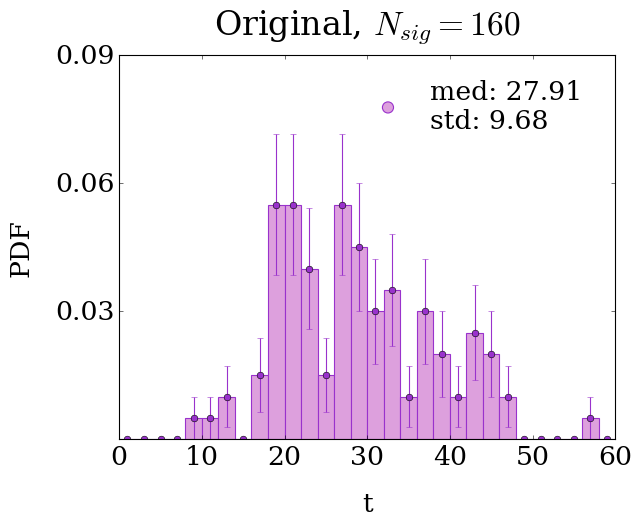

In [18]:
pu.plot_t_distribution(no_permute_2sigma_0_05cp,df=0,xmax=60,nbins=30,title='Original'+r', $N_{sig}=160$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='no_permute_2sigma_0_05cp_new')

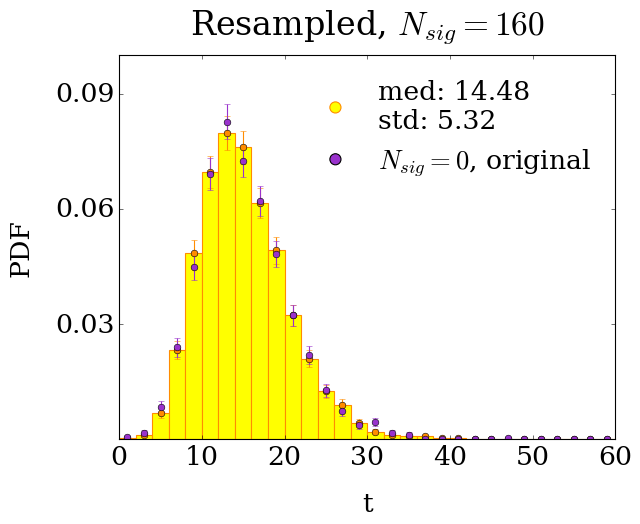

In [19]:
pu.plot_t_2distributions(permute_2sigma_0_05cp,no_permute_0sigma_0_05cp,df=False,xmax=60,nbins=30,colors1=['yellow','darkorange'],colors2=['plum','darkorchid'],alphas=[1,0],labels=[0,r'$N_{sig}=0$, original'],title='Resampled'+r', $N_{sig}=160$',save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_2sigma_0_05cp_new')

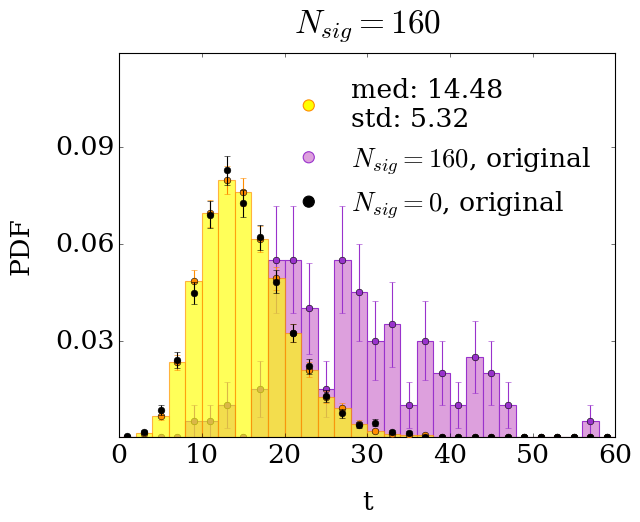

In [6]:
pu.plot_t_multiple_distributions([permute_2sigma_0_05cp,no_permute_2sigma_0_05cp,no_permute_0sigma_0_05cp],df=0,xmax=60,ymax=0.119,nbins=30
                                 ,bin_colors=['yellow',0,'black'],edge_colors=['darkorange',0,'black'],alphas=[0.65,1,0]
                                 ,labels=[0,r'$N_{sig}=160$, original',r'$N_{sig}=0$, original'],order=[1,0,2],title=r'$N_{sig}=160$'
                                 ,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name='permute_160_sig')

### D>1 background only plots

In [6]:
import numpy as np
import new_analysis_utils_table as au
import new_plot_utils as pu

In [7]:
%load_ext autoreload
%autoreload 2

In [13]:
check_loss = au.em_results("ch-em_vars-Mcoll:Lep0Pt_sig_types-ggH_taue:vbfH_taue_epochs-500000_architecture-2:4:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_loss2 = au.em_results("ch-em_vars-Mcoll:Lep0Pt:MLL_sig_types-ggH_taue:vbfH_taue_epochs-200000_architecture-3:5:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_loss3 = au.em_results("ch-em_vars-Mcoll:Lep0Pt_sig_types-ggH_taue:vbfH_taue_epochs-200000_architecture-2:4:1_WC-None_poiss-True_CP-0.25_0signals_1:2Ref_1:2Bkg.csv")
check_loss4 = au.em_results("ch-em_vars-Mcoll:Lep0Pt_sig_types-ggH_taue:vbfH_taue_epochs-200000_architecture-2:4:1_WC-None_poiss-True_0signals_1:2Ref_1:2Bkg.csv")
check_loss5 = au.exp_results("ch-exp_epochs-500000_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_1d_1_3_1 = au.exp_results("ch-exp_epochs-500000_architecture-1:3:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_1d_1_10_1 = au.exp_results("ch-exp_epochs-500000_architecture-1:10:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_linear_exp = au.exp_results("ch-exp_epochs-500000_architecture-2:4:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_quad_exp = au.exp_results("ch-exp_vars-squared_epochs-500000_architecture-2:4:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv")
check_eta_phi = au.em_results('ch-em_vars-Lep0Eta:Lep0Phi_norm-1_epochs-500000_architecture-2:4:1_WC-None_poiss-True_CP-0.05_0signals_1:2Ref_1:2Bkg.csv')

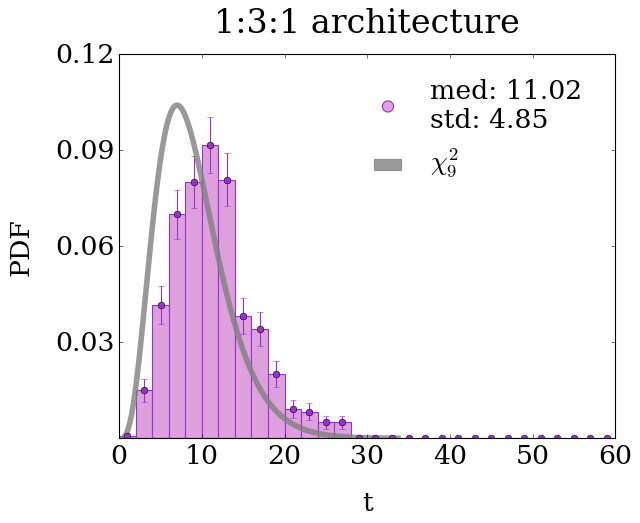

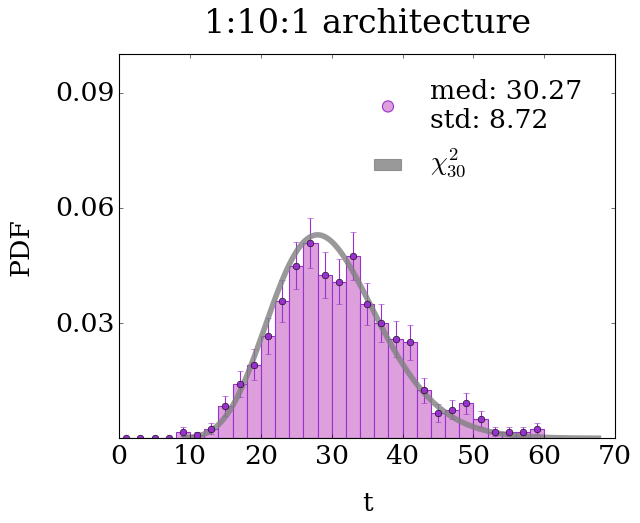

In [17]:
pu.plot_t_distribution(check_1d_1_3_1,df=9,xmax=60,nbins=30,ymax=0.12,title='1:3:1 architecture')
pu.plot_t_distribution(check_1d_1_10_1,df=30,xmax=60,nbins=30,title='1:10:1 architecture')

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


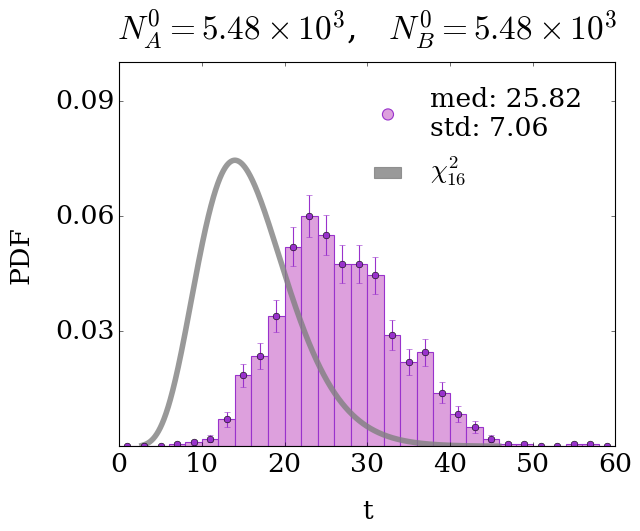

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


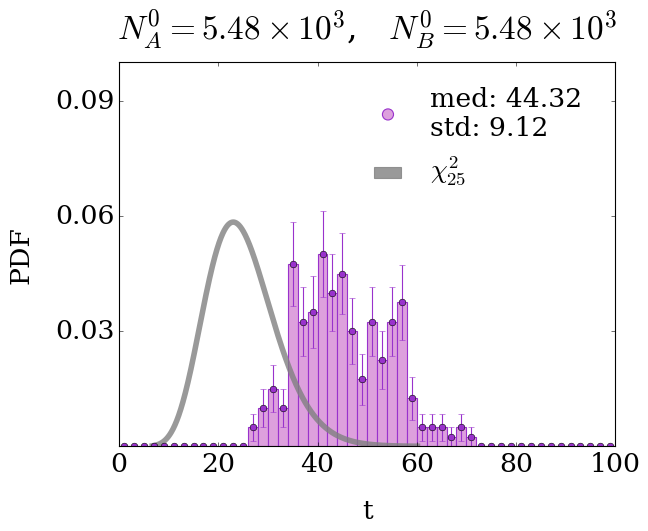

$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


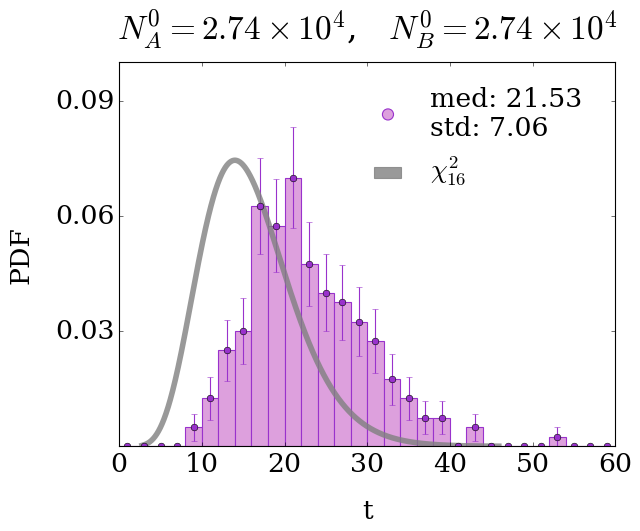

$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


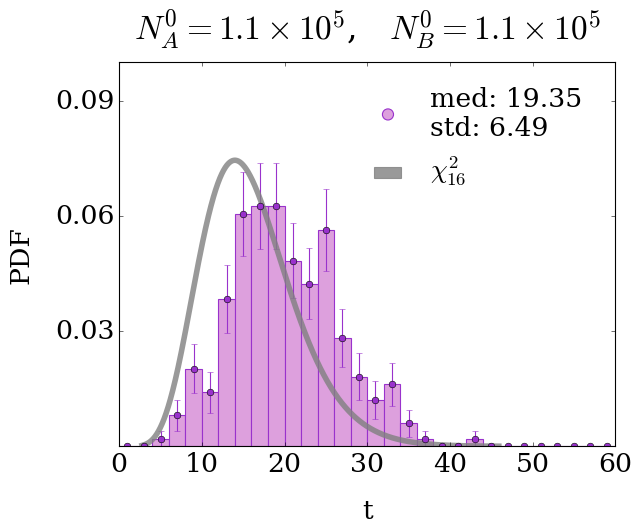

In [39]:
pu.plot_t_distribution(check_loss,df=16,xmax=60,nbins=30)
pu.plot_t_distribution(check_loss2,df=25,xmax=100,nbins=50)
pu.plot_t_distribution(check_loss3,df=16,xmax=60,nbins=30)
pu.plot_t_distribution(check_loss4,df=16,xmax=60,nbins=30)

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


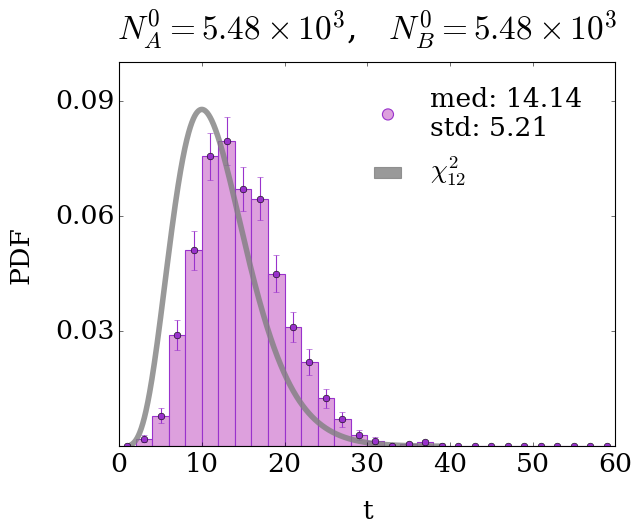

In [8]:
pu.plot_t_distribution(check_loss5,df=12,xmax=60,nbins=30)

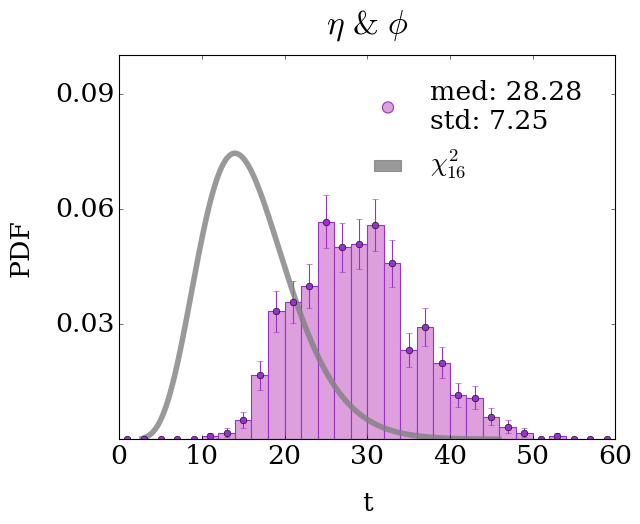

In [21]:
pu.plot_t_distribution(check_eta_phi,df=16,xmax=60,nbins=30,title=r'$\eta\ &\ \phi$')

$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


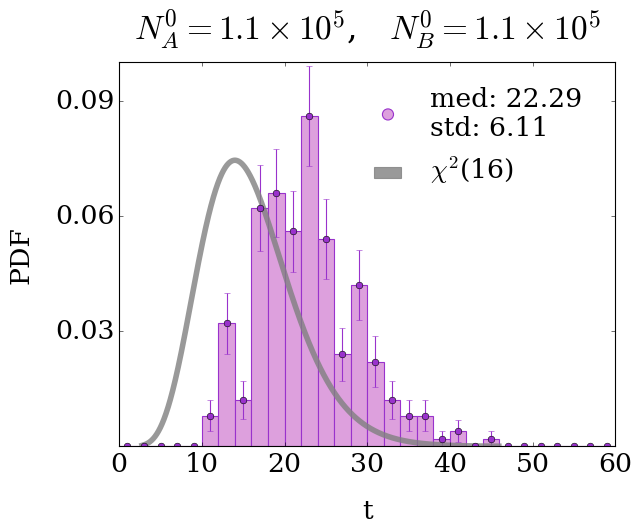

In [7]:
file_1cp = au.exp_results('ch-em_vars-Mcoll:Lep0Pt_sig_types-ggH_taue:vbfH_taue_epochs-500000_architecture-2:4:1_WC-None_poiss-True_0signals_1:2Ref_1:2Bkg.csv')
pu.plot_t_distribution(file_1cp,df=16,xmax=60,nbins=30)

In [9]:
NPLM1e5 = au.results('ch-gauss_epochs-150000_architecture-2:5:1_NPLM-True_WC-1.35_Sig_loc-1.5_Sig_scale-0.1_poiss-True_CP-0.45644_ND-10000_0signals_1Ref_1:10Bkg.csv')
NPLM2e5 = au.results('ch-gauss_epochs-150000_architecture-2:5:1_NPLM-True_WC-1.35_Sig_loc-1.5_Sig_scale-0.1_poiss-True_CP-0.45644_ND-10000_0signals_2Ref_1:10Bkg.csv')
NPLM1e4 = au.results('ch-gauss_epochs-150000_architecture-2:5:1_NPLM-True_WC-1.35_Sig_loc-1.5_Sig_scale-0.1_poiss-True_CP-0.45644_ND-10000_0signals_1:10Ref_1:10Bkg.csv')
SYM1e4 = au.results('ch-gauss_epochs-150000_architecture-2:5:1_WC-None_Sig_loc-1.5_Sig_scale-0.1_poiss-True_CP-0.45644_0signals_1:10Ref_1:10Bkg.csv')

In [22]:
dictNPLM1e5=NPLM1e5.get_t_history_dict()

In [27]:
np.median(dictNPLM1e5[149000])

10.109647750854492

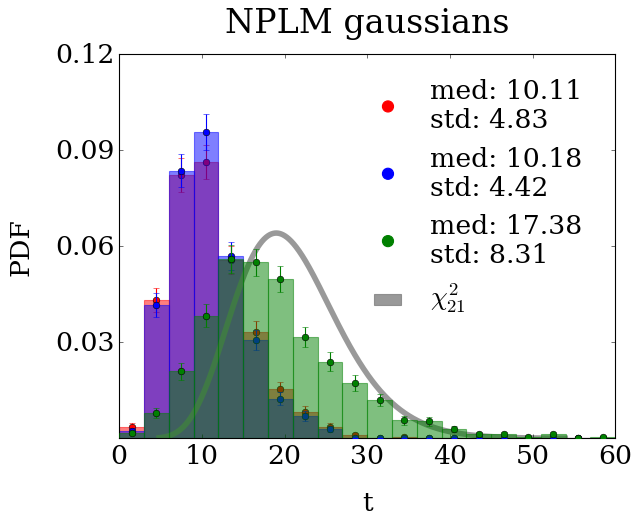

In [34]:
pu.plot_t_multiple_distributions([NPLM1e5,NPLM2e5,NPLM1e4],df=21,xmax=60,ymax=0.12,nbins=20,bin_colors=['red','blue','green'],edge_colors=['red','blue','green'],title='NPLM gaussians')

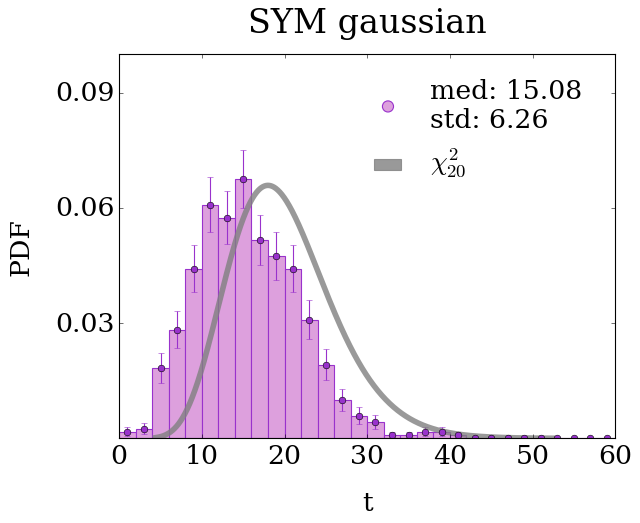

In [11]:
pu.plot_t_distribution(SYM1e4,df=20,xmax=60,nbins=30,title='SYM gaussian')

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


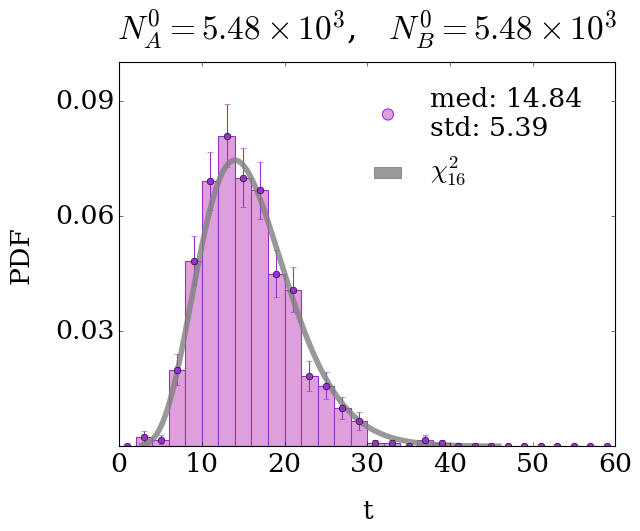

In [4]:
pu.plot_t_distribution(check_linear_exp,df=16,xmax=60,nbins=30)

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


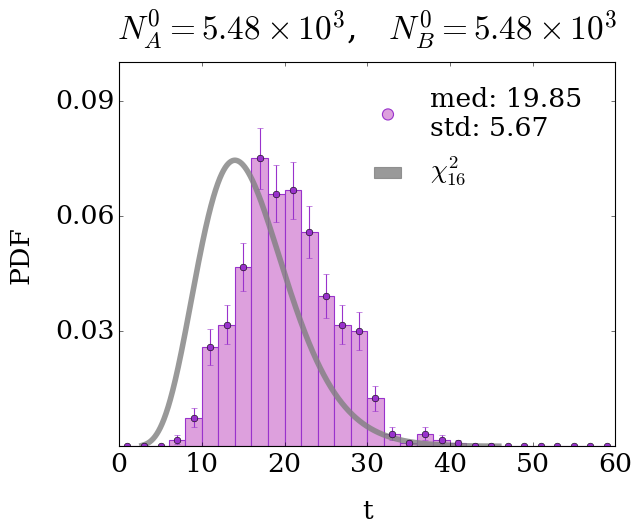

In [5]:
pu.plot_t_distribution(check_quad_exp,df=16,xmax=60,nbins=30)

# Not in paper

### Bkg-obly plots

em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:2Ref_1:24Bkg.csv
$1.1\times {10}^{5}$
$9.13\times {10}^{3}$


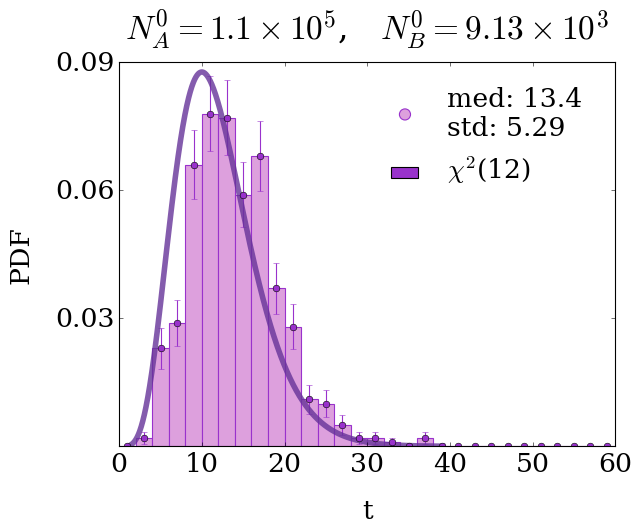

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_3:8Ref_3:8Bkg.csv
$8.22\times {10}^{4}$
$8.22\times {10}^{4}$


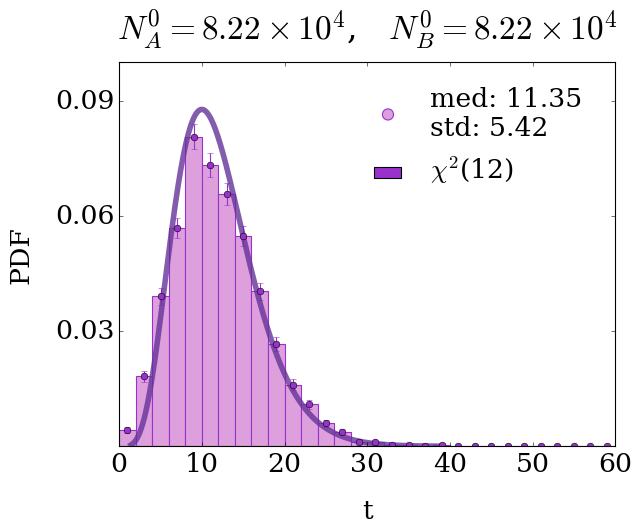

em500000epochs_tau500000epochs_delta1000patience_delta0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


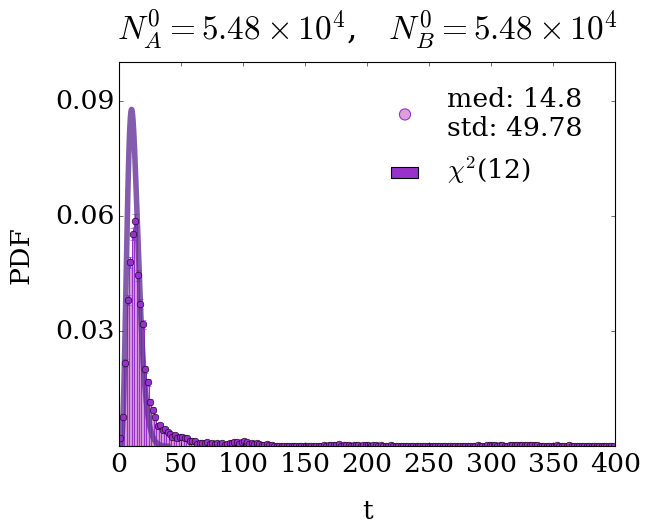

$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


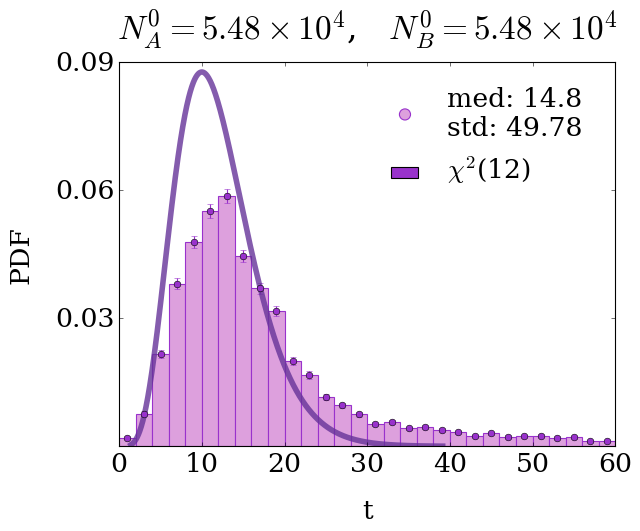

exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:10Bkg.csv
$1.1\times {10}^{4}$
$1.09\times {10}^{3}$


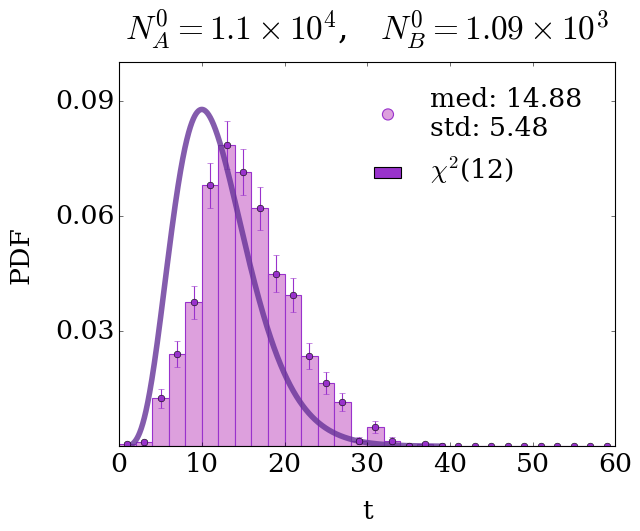

em500000epochs_tau30BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
em500000epochs_tau2BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
old_em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:2Ref_1:2Bkg.csv
failed
em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:8Ref_1:8Bkg.csv
$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


em500000epochs_tau0signals_1:4Ref_1:4Bkg_data=Bkg+Ref.csv
failed
em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv
$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


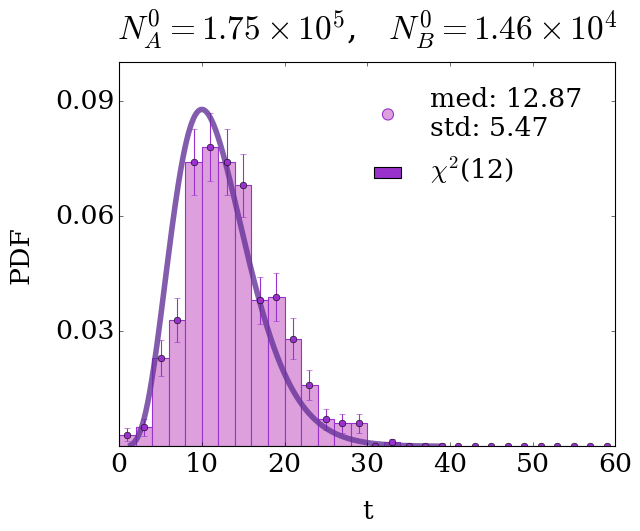

pdf_em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:2Ref_1:2Bkg.csv
failed
pdf_em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_4:5Ref_1:5Bkg.csv
failed
em500000epochs_tau100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv
$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


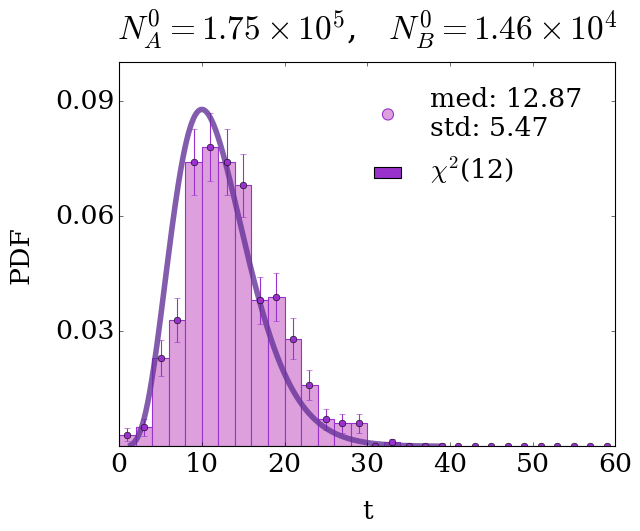

em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:16Ref_1:16Bkg.csv
$1.37\times {10}^{4}$
$1.37\times {10}^{4}$


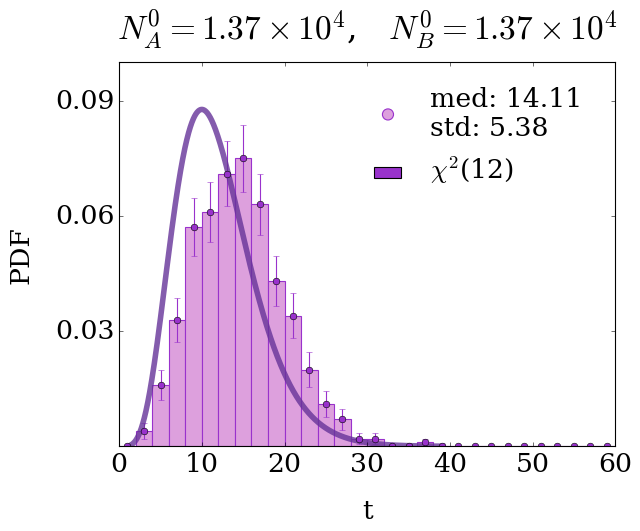

exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1:100Bkg.csv
$2.19\times {10}^{5}$
$2.19\times {10}^{3}$


em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:8Ref_1:8Bkg.csv
$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


em500000epochs_tau100BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
em500000epochs_tau0signals_4:5Ref_1:5Bkg.csv
failed
em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


pdf_em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_1:2Ref_1:2Bkg.csv
failed
em500000epochs_tau1BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1Ref_1:10Bkg.csv
$2.19\times {10}^{5}$
$2.19\times {10}^{4}$


em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonantTruebinned0.05resolution0signals_1:8Ref_1:8Bkg.csv
$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


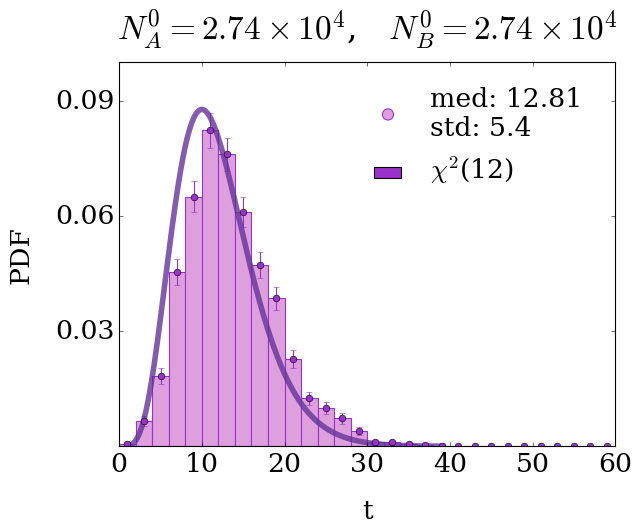

em500000epochs_tau1.3BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
old_em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_4:5Ref_1:15Bkg.csv
$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


em500000epochs_tau0signals_1:8Ref_1:8Bkg.csv
$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


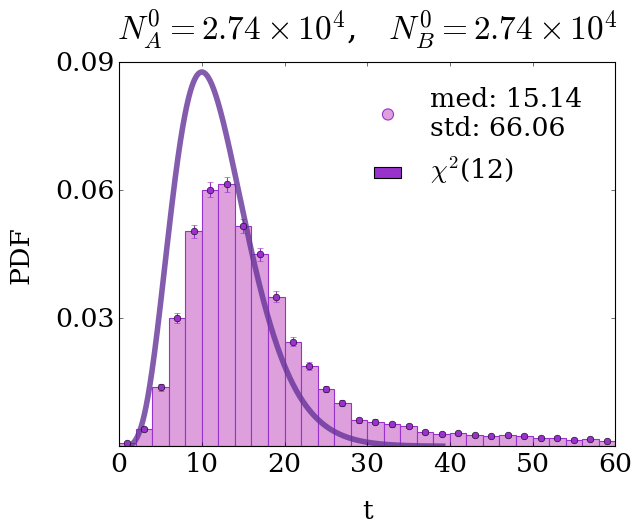

exp500000epochs_tauFalseNPLMTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
failed
old_em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_4:5Ref_1:5Bkg.csv
failed
em500000epochs_tau0signals_4:5Ref_1:15Bkg.csv
$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


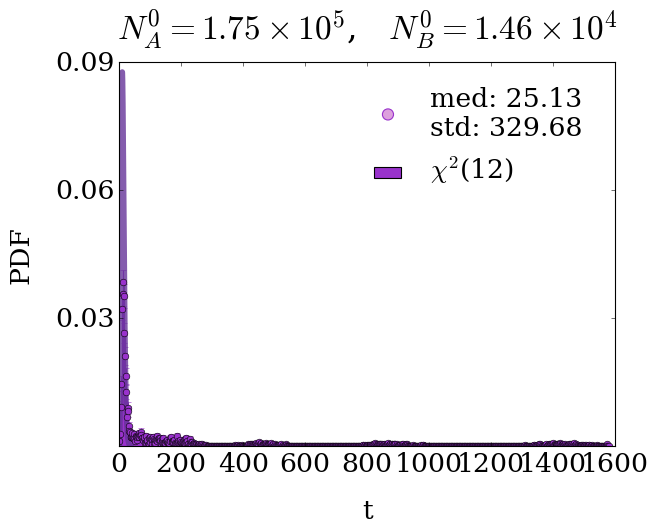

$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


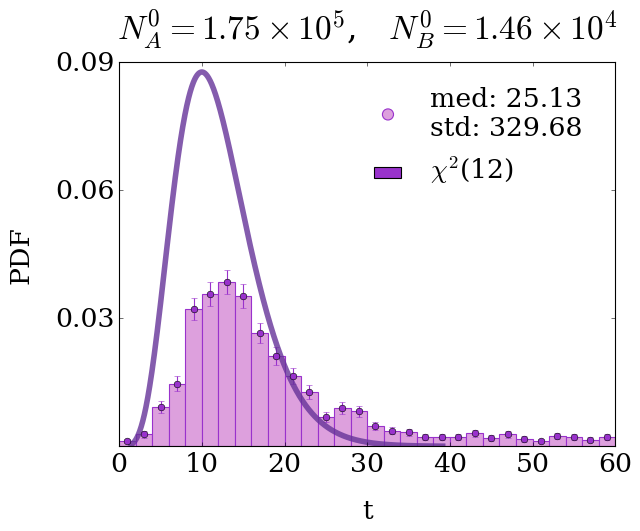

pdf_em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_4:5Ref_1:5Bkg.csv
failed
exp500000epochs_tauFalseNPLMTrueN_poiss0signals_1Ref_1:100Bkg.csv
failed
em500000epochs_tau0signals_1:16Ref_1:16Bkg.csv
$1.37\times {10}^{4}$
$1.37\times {10}^{4}$


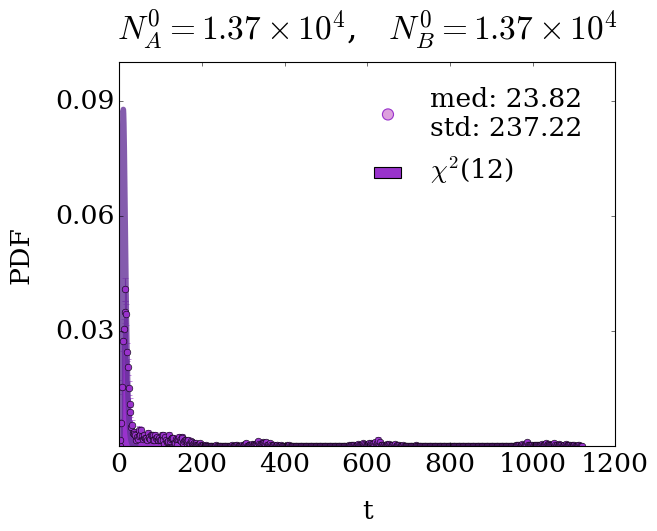

$1.37\times {10}^{4}$
$1.37\times {10}^{4}$


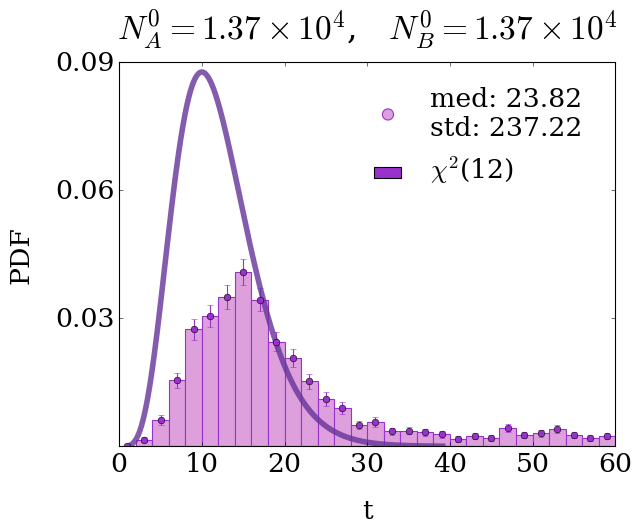

pdf_em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_100:101Ref_1:101Bkg.csv
failed
exp500000epochs_tauFalseNPLMTrueN_poiss0signals_1Ref_1:10Bkg.csv
failed
em500000epochs_tau1.5BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
em500000epochs_tau1.25BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv
failed
em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


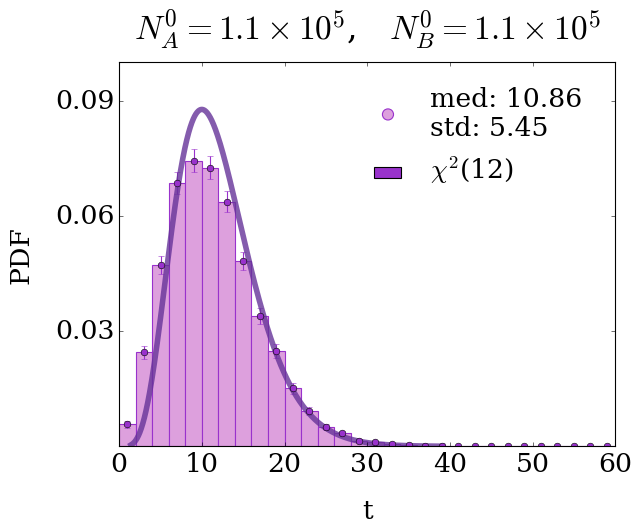

em500000epochs_tau0signals_1:4Ref_1:48Bkg.csv
failed
em500000epochs_tau0signals_1:2Ref_1:2Bkg.csv
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


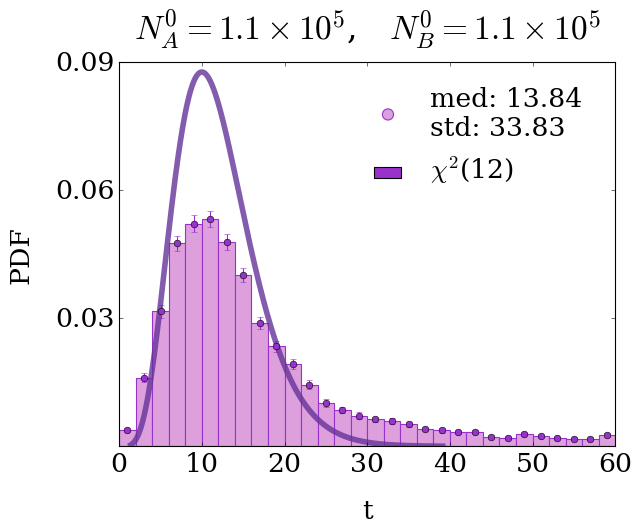

em500000epochs_tau1.25BSMweight_clipping0signals_1:2Ref_1:2Bkg.csv
failed
em500000epochs_tau0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


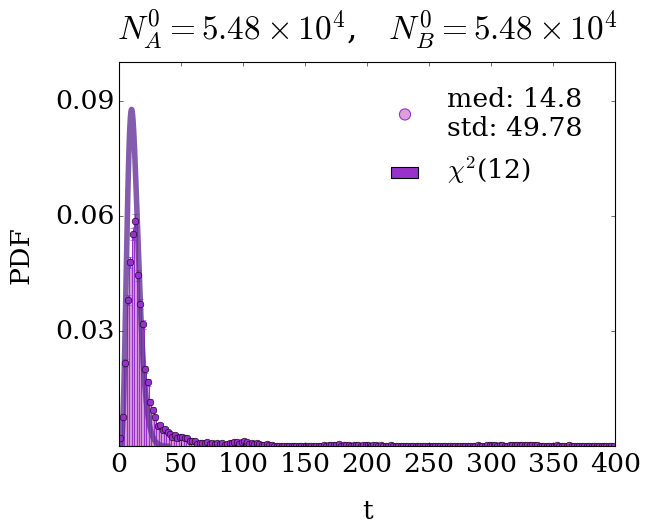

$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


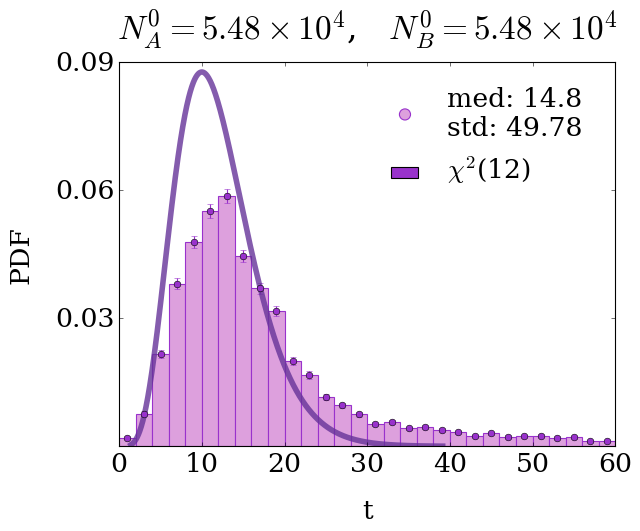

em500000epochs_tau1.1BSMweight_clipping0signals_49:100Ref_49:100Bkg.csv
failed
em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


em500000epochs_tau0signals_1:2Ref_1:24Bkg.csv
$1.1\times {10}^{5}$
$9.13\times {10}^{3}$


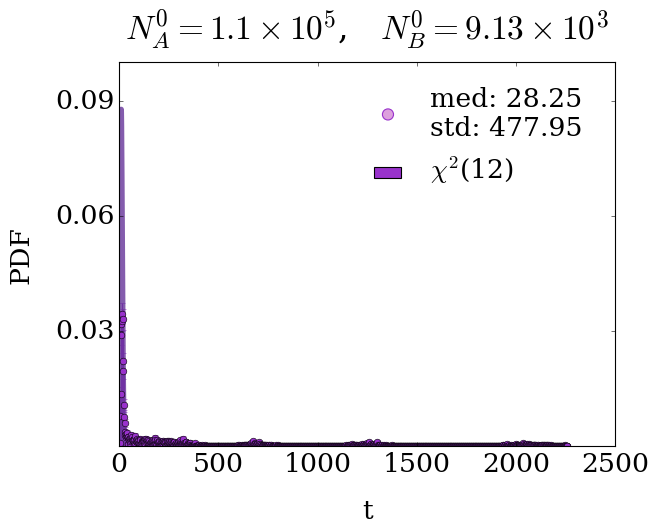

$1.1\times {10}^{5}$
$9.13\times {10}^{3}$


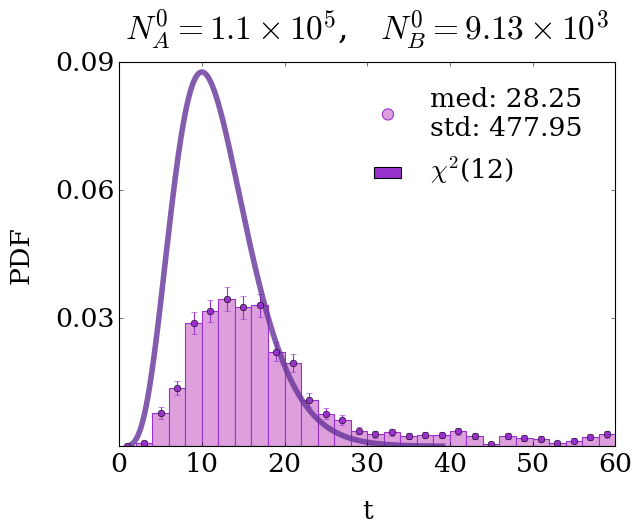

exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1Ref_1:100Bkg.csv
$1.1\times {10}^{4}$
$1.09\times {10}^{2}$


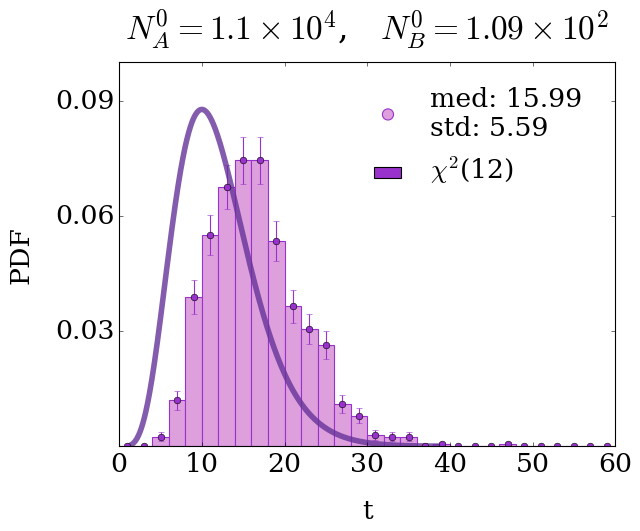

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


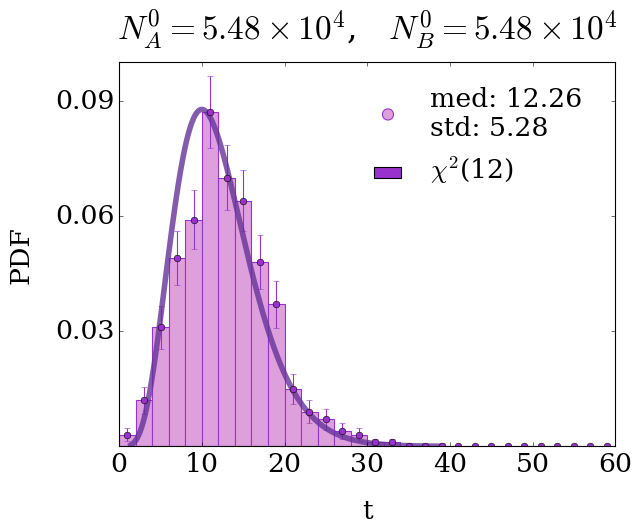

exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:2Ref_1:2Bkg.csv
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


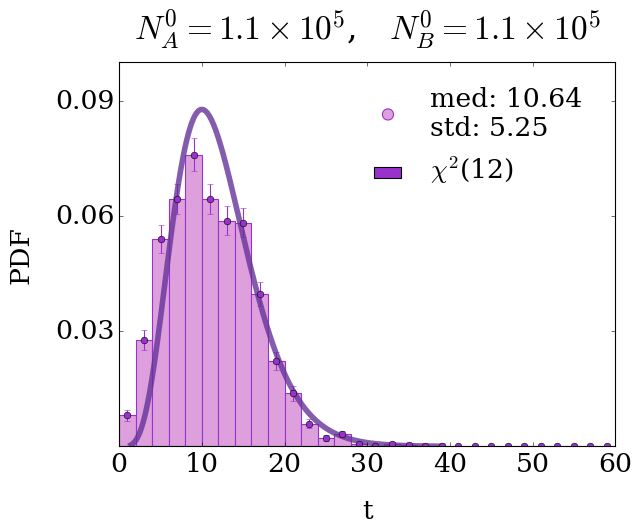

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_4:5Ref_1:15Bkg.csv
$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


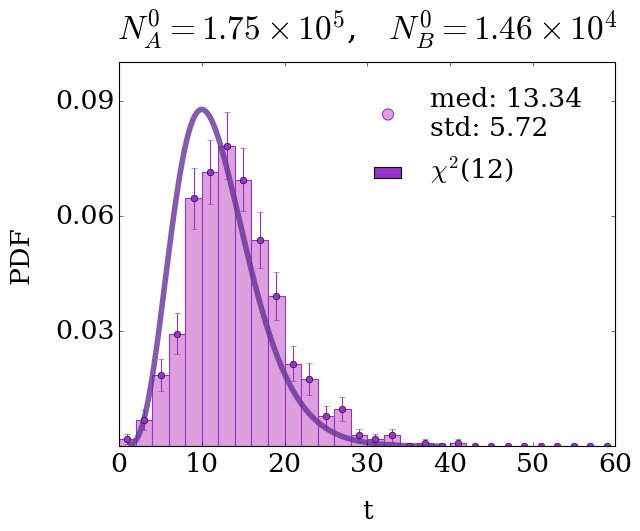

exp500000epochs_tau500000epochs_deltaTrueNPLMNoneBSMweight_clippingTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
failed
em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_13:30Ref_13:30Bkg.csv
$9.49\times {10}^{4}$
$9.49\times {10}^{4}$


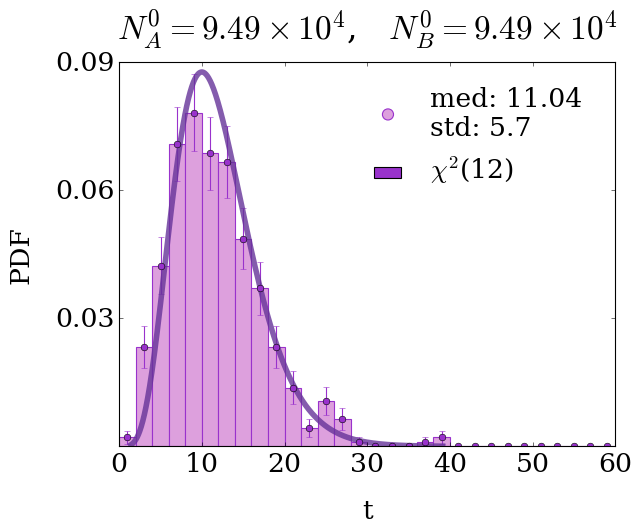

em500000epochs_tau100BSMweight_clipping0signals_4:5Ref_1:15Bkg.csv
$1.75\times {10}^{5}$
$1.46\times {10}^{4}$


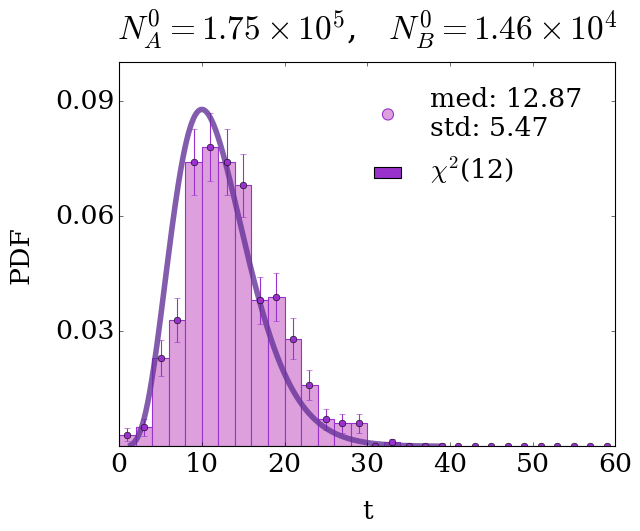

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_1:8Ref_1:8Bkg.csv
$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


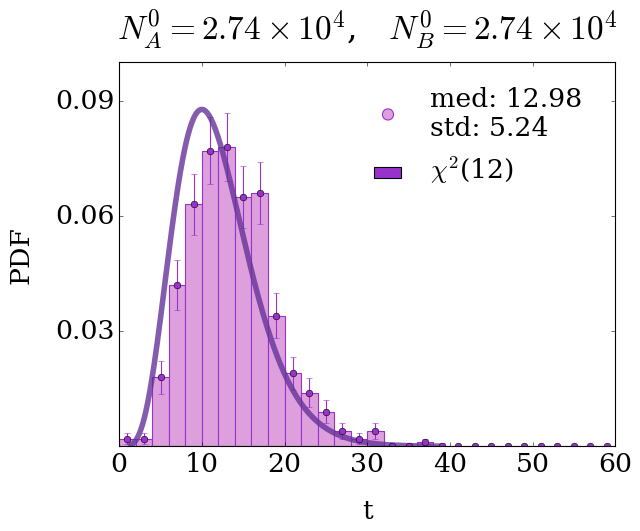

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:8Ref_1:8Bkg.csv
$2.74\times {10}^{4}$
$2.74\times {10}^{4}$


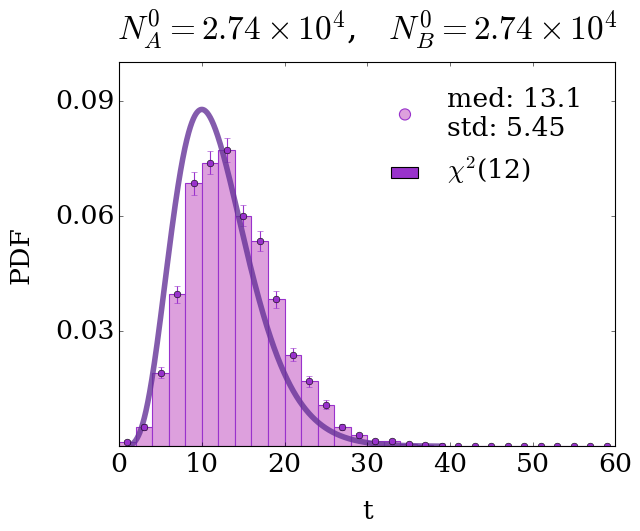

exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping6.4Sig_locTrueN_poissFalseresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement23910original_seed0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


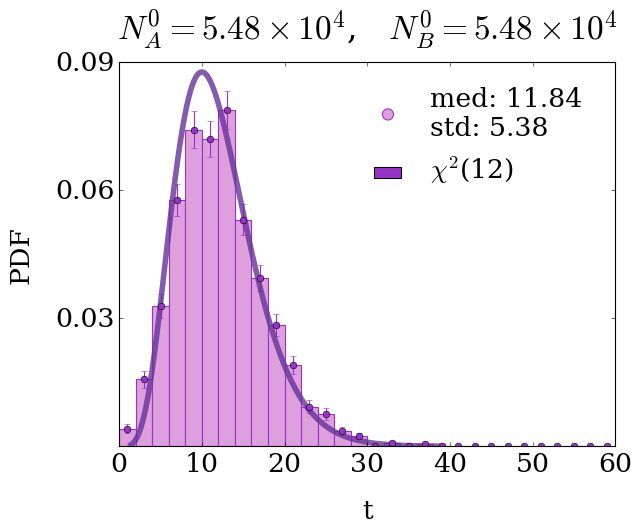

exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


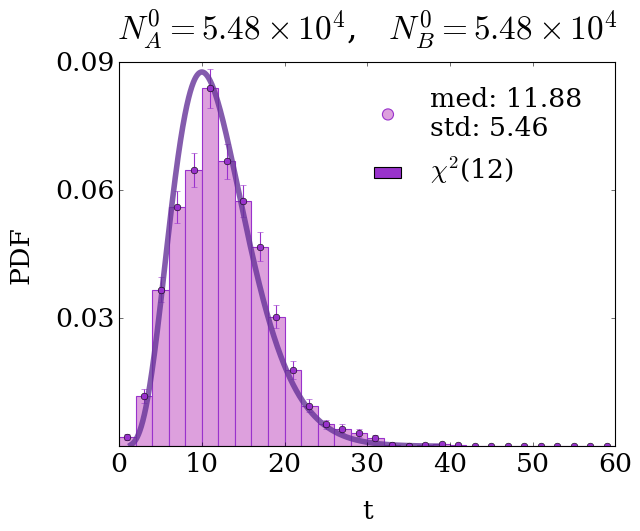

exp500000epochs_tau500000epochs_deltaTrueNPLMTrueN_poiss0signals_1:2Ref_1:2Bkg.csv
failed
em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_1:2Ref_1:24Bkg.csv
$1.1\times {10}^{5}$
$9.13\times {10}^{3}$


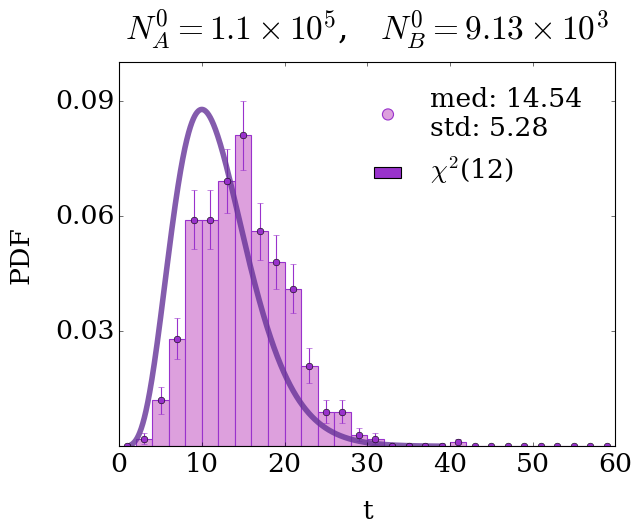

exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:2Ref_1:2Bkg.csv
$1.1\times {10}^{5}$
$1.1\times {10}^{5}$


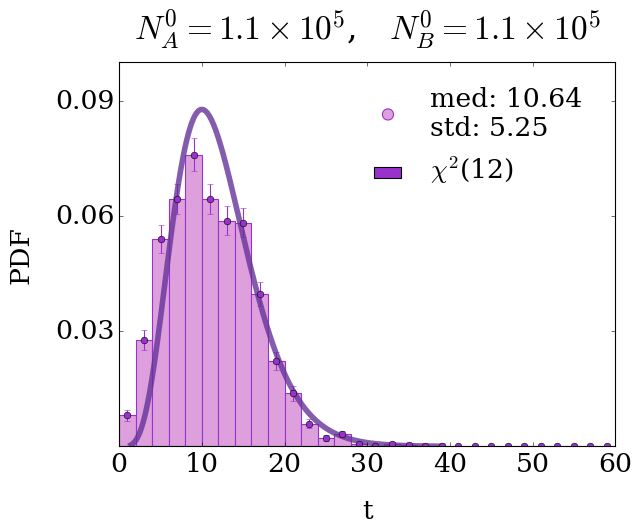

exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


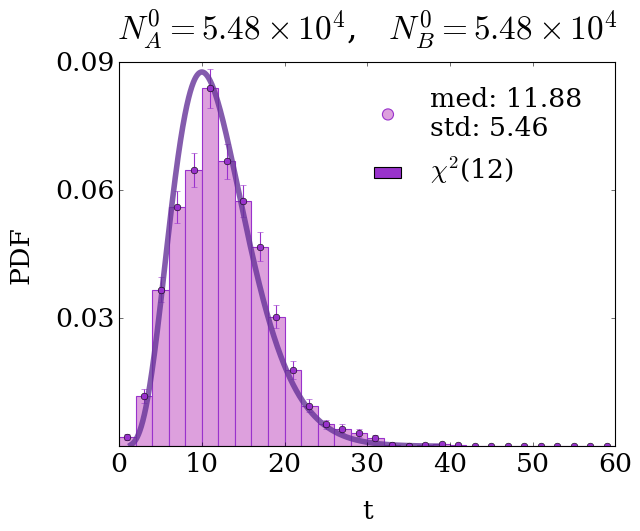

em500000epochs_tau500000epochs_delta1000patience_delta100BSMweight_clipping0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


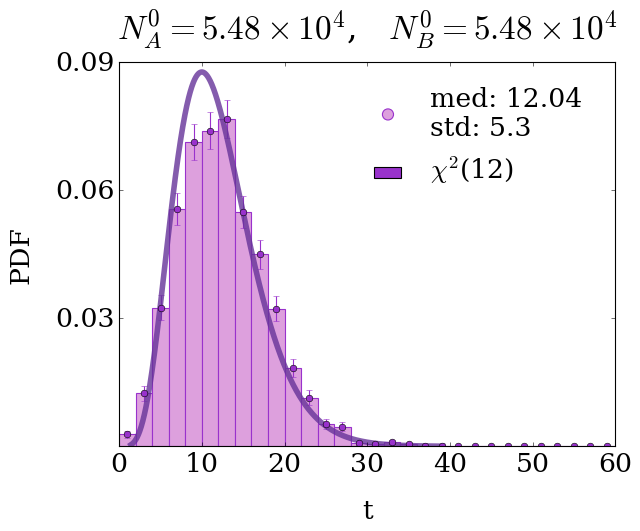

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clipping0signals_1:16Ref_1:16Bkg.csv
$1.37\times {10}^{4}$
$1.37\times {10}^{4}$


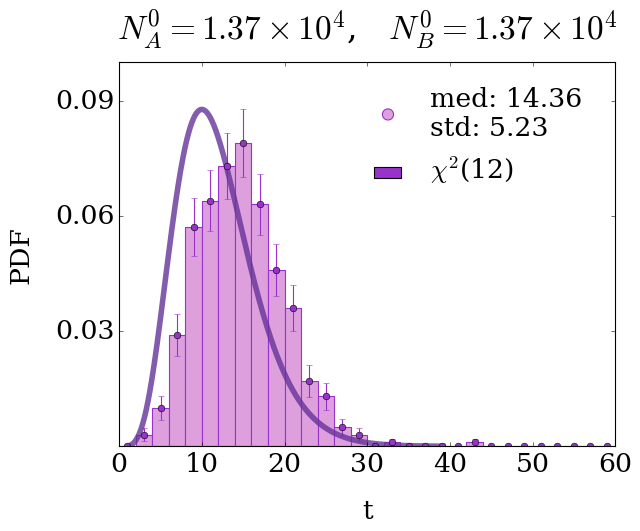

exp500000epochs_tau2000patience_tau500000epochs_delta2000patience_deltaNoneBSMweight_clipping6.4Sig_locTrueN_poissFalseresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement23910original_seed0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


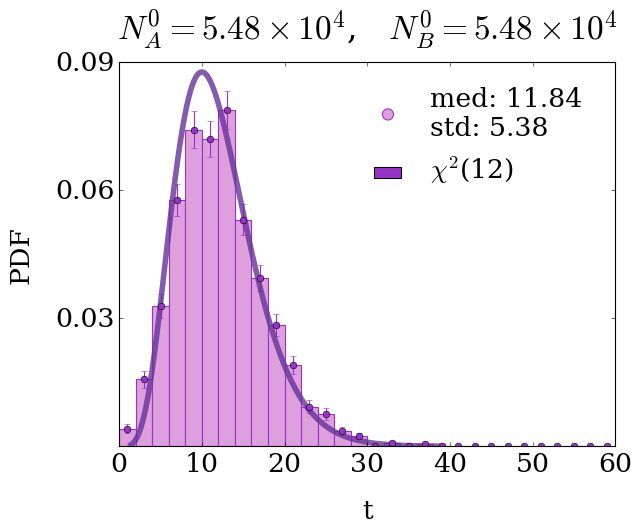

em500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


em_Mcoll500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0signals_3:8Ref_3:8Bkg.csv
$8.22\times {10}^{4}$
$8.22\times {10}^{4}$


exp500000epochs_tau500patience_tau500000epochs_delta500patience_deltaNoneBSMweight_clipping6.4Sig_locTrueN_poissFalseresonantTrueresamplepermutelabel_methodfixedN_methodTruereplacement23910original_seed0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


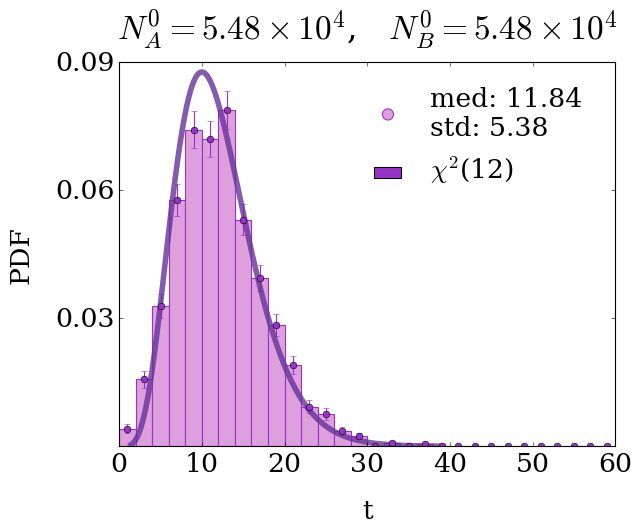

exp500000epochs_tau2000patience_tau500000epochs_delta2000patience_deltaNoneBSMweight_clipping1.6Sig_locTrueN_poissTrueresonant0signals_1:4Ref_1:4Bkg.csv
$5.48\times {10}^{4}$
$5.48\times {10}^{4}$


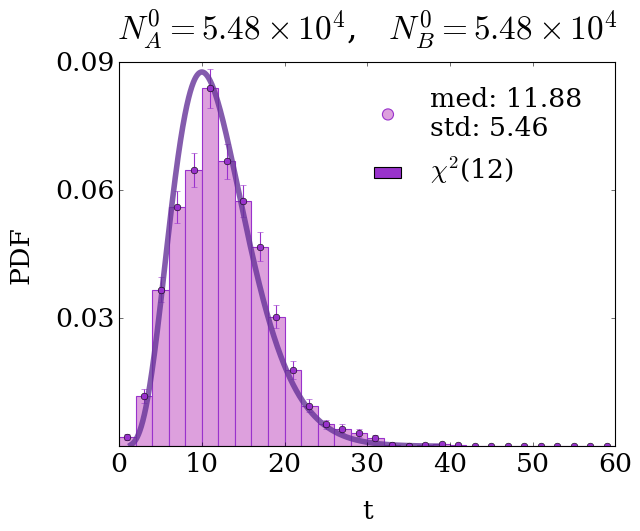

In [15]:
bkg_only_files = glob.glob('/srv01/agrp/yuvalzu/storage_links/NPLM_package/training_outcomes/*[a-z]0sig*.csv')+glob.glob('/srv01/tgrp/inbarsav/NPLM/NPLM_package/training_outcomes/*[a-z]0sig*.csv')
for file in bkg_only_files:
    file = file.split('/')[-1]
    print(file)
    try:
        bkg = au.exp_results(file) if 'exp' in file else au.em_results(file)
        if int(round(max(bkg.read_final_t_csv()[0]),-1))>=60:
            xmax = int(round(max(bkg.read_final_t_csv()[0]),-1))+10
            nbins = xmax//2
            pu.plot_t_distribution(bkg,df=12,xmax=xmax,nbins=nbins,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=file.replace('.csv','')+f'_xmax_{xmax}')
            pu.plot_t_distribution(bkg,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=file.replace('.csv','')+f'_xmax_60')
        else:
            pu.plot_t_distribution(bkg,df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',file_name=file.replace('.csv',''))
    except:
        print('failed')

$5.48\times {10}^{3}$
$5.48\times {10}^{3}$


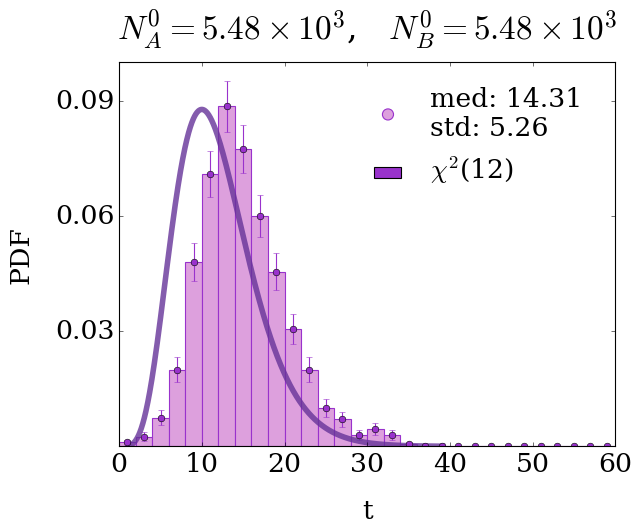

In [11]:
pu.plot_t_distribution(au.exp_results('exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg.csv'),
                       df=12,xmax=60,nbins=30,save=True,save_path='/srv01/agrp/yuvalzu/scripts/NPLM_package/plots/',
                       file_name='exp500000epochs_tau500000epochs_delta1000patience_deltaNoneBSMweight_clippingTrueN_poiss0.05combined_portion0signals_1:2Ref_1:2Bkg')